# Objective 4: Comparative Analysis of Aneurysm and Pipe Flow Simulations

This notebook loads velocity and wall shear stress (WSS) data from both aneurysm and pipe flow simulations using different methods (standard BGK and non-Newtonian BGK) to enable comparative analysis.

## Import Required Libraries

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import time
import sys
import math

# Add simulation_src to path to import utils
sys.path.append('../simulation_src')
from utils.load_csv import load_csv_data

## Define Simulation Paths

In [2]:
# Define the base directory where the simulation results are located
base_dir = Path.cwd()




# Define paths for pipe flow simulations
pipe_tdzh_nnbgk_folder = base_dir / '../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk'
pipe_tdzh_bgk_folder = base_dir / '../results/pipe_flow/time_dependent_zouhe_standard_bgk'
pipe_zh_bgk_folder = base_dir / '../results/pipe_flow/standard_zouhe_standard_bgk'

# Define paths for aneurysm simulations
aneurysm_tdzh_nnbgk_folder = base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh'

# Define parameter file paths
pipe_tdzh_nnbgk_params = pipe_tdzh_nnbgk_folder / 'parameters' / 'pipe_tdzh_nnbgk_params.json'
pipe_tdzh_bgk_params = pipe_tdzh_nnbgk_folder / 'parameters' / 'pipe_tdzh_bgk_params.json'
pipe_zh_bgk_params = pipe_zh_bgk_folder / 'parameters' / 'pipe_zh_bgk_params.json'

aneurysm_tdzh_nnbgk_params = aneurysm_tdzh_nnbgk_folder / 'parameters' / 'aneurysm_tdzh_nnbgk_params.json'

# Print paths to confirm
print("Simulation paths:")
print(f"Pipe ZH BGK: {pipe_zh_bgk_folder}")
print(f"Pipe TD-ZH NNBGK: {pipe_tdzh_nnbgk_folder}")
print(f"Pipe TD-ZH BGK: {pipe_tdzh_bgk_folder}")
print(f"Aneurysm TD-ZH NNBGK: {aneurysm_tdzh_nnbgk_folder}")

Simulation paths:
Pipe ZH BGK: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/standard_zouhe_standard_bgk
Pipe TD-ZH NNBGK: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk
Pipe TD-ZH BGK: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_standard_bgk
Aneurysm TD-ZH NNBGK: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh


## Load Simulation Parameters

In [3]:
# Function to load parameters
def load_params(param_file):
    try:
        with open(param_file, 'r') as f:
            params = json.load(f)
        print(f"Successfully loaded parameters from {param_file}")
        return params
    except Exception as e:
        print(f"Error loading parameters from {param_file}: {e}")
        return None

# Load parameters for each simulation
pipe_zh_bgk_parameters = load_params(pipe_zh_bgk_params) if pipe_zh_bgk_params.exists() else None
pipe_tdzh_nnbgk_parameters = load_params(pipe_tdzh_nnbgk_params) if pipe_tdzh_nnbgk_params.exists() else None

aneurysm_tdzh_nnbgk_parameters = load_params(aneurysm_tdzh_nnbgk_params) if aneurysm_tdzh_nnbgk_params.exists() else None

# Extract key simulation parameters
def extract_key_params(params, sim_name):
    if params is None:
        print(f"No parameters available for {sim_name}")
        return {}
    
    try:
        # Extract key parameters
        key_params = {
            'dt': params['input_parameters'].get('dt', 'N/A'),
            'dx': params['input_parameters'].get('dx', 'N/A'),
            'fps': params['input_parameters'].get('fps', 'N/A'),
            'kinematic_viscosity': params['input_parameters'].get('kinematic_viscosity', 'N/A')
        }
        
        print(f"\nKey parameters for {sim_name}:")
        for key, value in key_params.items():
            print(f"  {key}: {value}")
        
        return key_params
    except Exception as e:
        print(f"Error extracting key parameters for {sim_name}: {e}")
        return {}

# Extract key parameters for each simulation
pipe_zh_bgk_key_params = extract_key_params(pipe_zh_bgk_parameters, "Pipe ZH BGK")
pipe_tdzh_nnbgk_key_params = extract_key_params(pipe_tdzh_nnbgk_parameters, "Pipe TD-ZH NNBGK")

aneurysm_tdzh_nnbgk_key_params = extract_key_params(aneurysm_tdzh_nnbgk_parameters, "Aneurysm TD-ZH NNBGK")

Successfully loaded parameters from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/standard_zouhe_standard_bgk/parameters/pipe_zh_bgk_params.json
Successfully loaded parameters from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/pipe_flow/time_dependent_zouhe_non_newtonian_bgk/parameters/pipe_tdzh_nnbgk_params.json

Key parameters for Pipe ZH BGK:
  dt: 1e-05
  dx: 2e-05
  fps: 100
  kinematic_viscosity: 3.3143939393939395e-06

Key parameters for Pipe TD-ZH NNBGK:
  dt: 1e-05
  dx: 2e-05
  fps: 100
  kinematic_viscosity: 3.3143939393939395e-06
No parameters available for Aneurysm TD-ZH NNBGK


## Load Velocity Data

In [4]:
# Function to load velocity data
def load_velocity_data(sim_folder, sim_name):
    data_dir = sim_folder / 'processed_data' / 'raw_fields'
    if not data_dir.exists():
        print(f"Data directory not found for {sim_name}: {data_dir}")
        return None
    
    try:
        print(f"\nLoading velocity data for {sim_name}...")
        # Load frame mapping
        frame_mapping_file = data_dir / 'frame_mapping.npz'
        if frame_mapping_file.exists():
            frame_mapping = np.load(frame_mapping_file)
            frame_numbers = frame_mapping['frame_numbers']
            frame_indices = frame_mapping['frame_indices']
            print(f"Found {len(frame_numbers)} frames, range: {min(frame_numbers)} to {max(frame_numbers)}")
        else:
            print(f"Frame mapping file not found: {frame_mapping_file}")
            return None
        
        # Load velocity components
        start_time = time.time()
        
        # Load u_x component
        u_x_file = data_dir / 'u_x.npz'
        if u_x_file.exists():
            u_x_data = np.load(u_x_file)['data']
            print(f"Loaded u_x data with shape: {u_x_data.shape}")
        else:
            print(f"u_x data file not found: {u_x_file}")
            u_x_data = None
        
        # Load u_y component
        u_y_file = data_dir / 'u_y.npz'
        if u_y_file.exists():
            u_y_data = np.load(u_y_file)['data']
            print(f"Loaded u_y data with shape: {u_y_data.shape}")
        else:
            print(f"u_y data file not found: {u_y_file}")
            u_y_data = None
        
        # Load u_magnitude
        u_magnitude_file = data_dir / 'u_magnitude.npz'
        if u_magnitude_file.exists():
            u_magnitude_data = np.load(u_magnitude_file)['data']
            print(f"Loaded u_magnitude data with shape: {u_magnitude_data.shape}")
        else:
            print(f"u_magnitude data file not found: {u_magnitude_file}")
            u_magnitude_data = None
        
        # Load grid dimensions
        dimensions_file = data_dir / 'dimensions.npz'
        if dimensions_file.exists():
            dimensions = np.load(dimensions_file)['data']
            print(f"Grid dimensions: {dimensions}")
        else:
            print(f"Dimensions file not found: {dimensions_file}")
            dimensions = None
        
        load_time = time.time() - start_time
        print(f"Data loaded in {load_time:.2f} seconds")
        
        return {
            'frame_numbers': frame_numbers,
            'frame_indices': frame_indices,
            'u_x': u_x_data,
            'u_y': u_y_data,
            'u_magnitude': u_magnitude_data,
            'dimensions': dimensions
        }
    
    except Exception as e:
        print(f"Error loading velocity data for {sim_name}: {e}")
        return None

# Load velocity data for each simulation
pipe_zh_bgk_velocity = load_velocity_data(pipe_zh_bgk_folder, "Pipe ZH BGK")
pipe_tdzh_nnbgk_velocity = load_velocity_data(pipe_tdzh_nnbgk_folder, "Pipe TD-ZH NNBGK")
aneurysm_tdzh_nnbgk_velocity = load_velocity_data(aneurysm_tdzh_nnbgk_folder, "Aneurysm TD-ZH NNBGK")


Loading velocity data for Pipe ZH BGK...
Found 101 frames, range: 0 to 100000
Loaded u_x data with shape: (101, 330, 751)
Loaded u_x data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_magnitude data with shape: (101, 330, 751)
Grid dimensions: [752 331   1]
Data loaded in 1.43 seconds

Loading velocity data for Pipe TD-ZH NNBGK...
Found 101 frames, range: 0 to 100000
Loaded u_magnitude data with shape: (101, 330, 751)
Grid dimensions: [752 331   1]
Data loaded in 1.43 seconds

Loading velocity data for Pipe TD-ZH NNBGK...
Found 101 frames, range: 0 to 100000
Loaded u_x data with shape: (101, 330, 751)
Loaded u_x data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_magnitude data with shape: (101, 330, 751)
Grid dimensions: [752 331   1]
Data loaded in 1.38 seconds

Loading velocity data for Aneurysm TD-ZH NNBGK...
Found 101 frames,

## Load Wall Shear Stress (WSS) Data

In [5]:
# Function to load WSS data
def load_wss_data(sim_folder, sim_name):
    data_dir = sim_folder / 'processed_data' / 'raw_fields'
    if not data_dir.exists():
        print(f"Data directory not found for {sim_name}: {data_dir}")
        return None
    
    try:
        print(f"\nLoading WSS data for {sim_name}...")
        start_time = time.time()
        
        # Load WSS x component
        wss_x_file = data_dir / 'wss_x.npz'
        if wss_x_file.exists():
            wss_x_data = np.load(wss_x_file)['data']
            print(f"Loaded wss_x data with shape: {wss_x_data.shape}")
        else:
            print(f"wss_x data file not found: {wss_x_file}")
            wss_x_data = None
        
        # Load WSS y component
        wss_y_file = data_dir / 'wss_y.npz'
        if wss_y_file.exists():
            wss_y_data = np.load(wss_y_file)['data']
            print(f"Loaded wss_y data with shape: {wss_y_data.shape}")
        else:
            print(f"wss_y data file not found: {wss_y_file}")
            wss_y_data = None
        
        # Load WSS magnitude
        wss_magnitude_file = data_dir / 'wss_magnitude.npz'
        if wss_magnitude_file.exists():
            wss_magnitude_data = np.load(wss_magnitude_file)['data']
            print(f"Loaded wss_magnitude data with shape: {wss_magnitude_data.shape}")
        else:
            print(f"wss_magnitude data file not found: {wss_magnitude_file}")
            wss_magnitude_data = None
        
        load_time = time.time() - start_time
        print(f"WSS data loaded in {load_time:.2f} seconds")
        
        return {
            'wss_x': wss_x_data,
            'wss_y': wss_y_data,
            'wss_magnitude': wss_magnitude_data
        }
    
    except Exception as e:
        print(f"Error loading WSS data for {sim_name}: {e}")
        return None

# Load WSS data for each simulation
pipe_zh_bgk_wss = load_wss_data(pipe_zh_bgk_folder, "Pipe ZH BGK")
pipe_tdzh_nnbgk_wss = load_wss_data(pipe_tdzh_nnbgk_folder, "Pipe TD-ZH NNBGK")
aneurysm_tdzh_nnbgk_wss = load_wss_data(aneurysm_tdzh_nnbgk_folder, "Aneurysm TD-ZH NNBGK")


Loading WSS data for Pipe ZH BGK...
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_magnitude data with shape: (101, 330, 751)
WSS data loaded in 1.15 seconds

Loading WSS data for Pipe TD-ZH NNBGK...
Loaded wss_magnitude data with shape: (101, 330, 751)
WSS data loaded in 1.15 seconds

Loading WSS data for Pipe TD-ZH NNBGK...
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_magnitude data with shape: (101, 330, 751)
WSS data loaded in 1.17 seconds

Loading WSS data for Aneurysm TD-ZH NNBGK...
Loaded wss_magnitude data with shape: (101, 330, 751)
WSS data loaded in 1.17 seconds

Loading WSS data for Aneurysm TD-ZH NNBGK...
Loaded wss_x data with shape: (101, 530, 751)
Loaded wss_x data with shape:

## Display Basic Information About Loaded Data

In [6]:
# Function to display basic data statistics
def display_data_stats(velocity_data, wss_data, sim_name):
    print(f"\n=== Basic statistics for {sim_name} ===\n")
    
    if velocity_data is None:
        print("No velocity data available.")
    else:
        u_magnitude = velocity_data.get('u_magnitude')
        if u_magnitude is not None and len(u_magnitude) > 0:
            first_frame = u_magnitude[0]
            non_zero_mask = first_frame > 0
            if np.any(non_zero_mask):
                print(f"Velocity statistics (first frame):")
                print(f"  Min: {first_frame[non_zero_mask].min():.6f}")
                print(f"  Max: {first_frame.max():.6f}")
                print(f"  Mean: {first_frame[non_zero_mask].mean():.6f}")
                print(f"  Std: {first_frame[non_zero_mask].std():.6f}")
            else:
                print("No non-zero velocity values found in first frame.")
    
    if wss_data is None:
        print("\nNo WSS data available.")
    else:
        wss_magnitude = wss_data.get('wss_magnitude')
        if wss_magnitude is not None and len(wss_magnitude) > 0:
            first_frame = wss_magnitude[0]
            non_zero_mask = first_frame > 0
            if np.any(non_zero_mask):
                print(f"\nWSS statistics (first frame):")
                print(f"  Min: {first_frame[non_zero_mask].min():.6f}")
                print(f"  Max: {first_frame.max():.6f}")
                print(f"  Mean: {first_frame[non_zero_mask].mean():.6f}")
                print(f"  Std: {first_frame[non_zero_mask].std():.6f}")
            else:
                print("No non-zero WSS values found in first frame.")

# Display statistics for each simulation
display_data_stats(pipe_zh_bgk_velocity, pipe_zh_bgk_wss, "Pipe ZH BGK")
display_data_stats(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss, "Pipe TD-ZH NNBGK")
display_data_stats(aneurysm_tdzh_nnbgk_velocity, aneurysm_tdzh_nnbgk_wss, "Aneurysm TD-ZH NNBGK")


=== Basic statistics for Pipe ZH BGK ===

Velocity statistics (first frame):
  Min: 0.007342
  Max: 0.512935
  Mean: 0.405685
  Std: 0.093966

WSS statistics (first frame):
  Min: 0.789463
  Max: 28.963310
  Mean: 1.366894
  Std: 1.678249

=== Basic statistics for Pipe TD-ZH NNBGK ===

Velocity statistics (first frame):
  Min: 0.000996
  Max: 0.161682
  Mean: 0.108296
  Std: 0.045777

WSS statistics (first frame):
  Min: 0.162501
  Max: 7.005670
  Mean: 0.235349
  Std: 0.434255

=== Basic statistics for Aneurysm TD-ZH NNBGK ===

Velocity statistics (first frame):
  Min: 0.000002
  Max: 0.160977
  Mean: 0.078606
  Std: 0.051404

WSS statistics (first frame):
  Min: 0.003322
  Max: 7.005581
  Mean: 0.171698
  Std: 0.435147


## Visualize Pipe Flow: Velocity and Wall Shear Stress

This section analyzes the pipe flow simulation, visualizing both velocity and wall shear stress fields together to understand the relationship between flow patterns and the resulting forces on the vessel walls.


Visualizing pipe flow for frame 100...


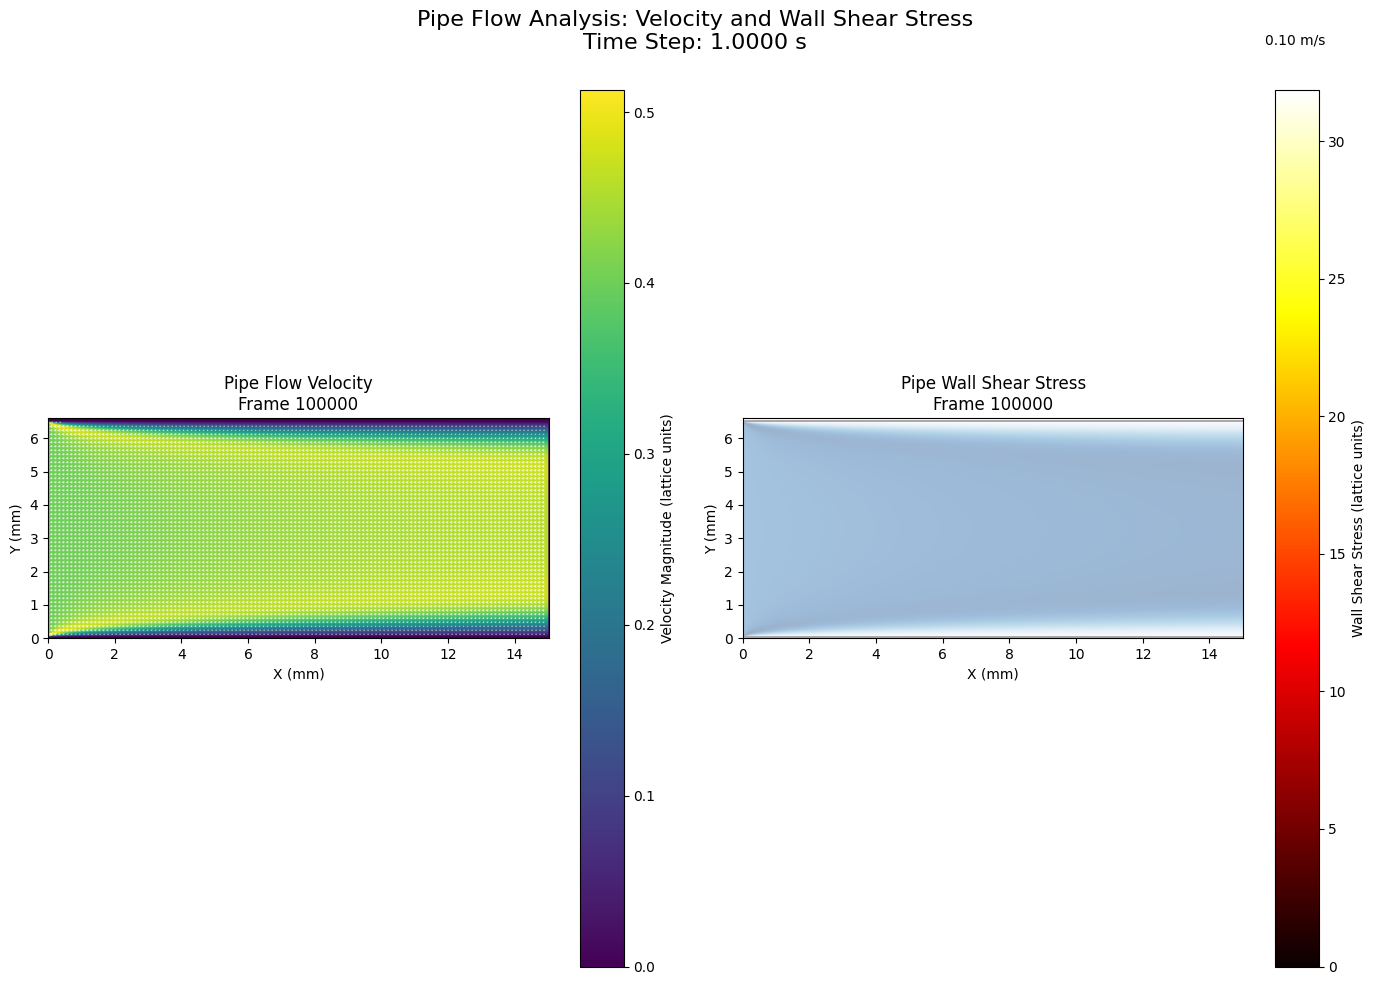

In [7]:
def visualize_pipe_flow(velocity_data, wss_data, frame_idx=1, subsample=6, velocity_scale=15, fig_size=(14, 10)):
    """Visualize pipe flow velocity and WSS for a specific frame.
    
    Args:
        velocity_data (dict): Dictionary containing velocity components and metadata
        wss_data (dict): Dictionary containing WSS components and metadata
        frame_idx (int): Index of the frame to visualize
        subsample (int): Factor to subsample the vector field for clearer visualization
        velocity_scale (float): Scaling factor for vector length
        fig_size (tuple): Size of the figure (width, height)
    """
    if velocity_data is None or wss_data is None:
        print("Missing velocity or WSS data for pipe flow")
        return
    
    # Extract frame data for velocity
    u_x = velocity_data.get('u_x')
    u_y = velocity_data.get('u_y')
    u_magnitude = velocity_data.get('u_magnitude')
    frame_numbers = velocity_data.get('frame_numbers')
    
    # Extract frame data for WSS
    wss_x = wss_data.get('wss_x')
    wss_y = wss_data.get('wss_y')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if (u_x is None or u_y is None or u_magnitude is None or frame_numbers is None or
        wss_x is None or wss_y is None or wss_magnitude is None):
        print("Missing required data components")
        return
    
    # Ensure frame_idx is valid
    if frame_idx >= len(u_x):
        frame_idx = len(u_x) // 2  # Use middle frame if specified index is invalid
        print(f"Specified frame index out of range. Using frame {frame_idx} instead.")
    
    # Get frame data
    frame_u_x = u_x[frame_idx]
    frame_u_y = u_y[frame_idx]
    frame_u_magnitude = u_magnitude[frame_idx]
    frame_num = frame_numbers[frame_idx]
    
    frame_wss_x = wss_x[frame_idx]
    frame_wss_y = wss_y[frame_idx]
    frame_wss_magnitude = wss_magnitude[frame_idx]
    
    # Create figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=fig_size)
    
    # Physical parameters
    dx = pipe_zh_bgk_key_params.get('dx', 2e-5)  # Default to 2e-5 if not available
    dt = pipe_zh_bgk_key_params.get('dt', 1e-5)  # Default to 1e-5 if not available
    
    # Grid dimensions
    ny, nx = frame_u_magnitude.shape
    
    # Convert to mm for display
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    
    # Get vessel parameters from simulation parameters if available
    if pipe_zh_bgk_parameters is not None:
        vessel_diameter_mm = pipe_zh_bgk_parameters['input_parameters'].get('vessel_diameter_mm', 6.5)
        vessel_length_mm = pipe_zh_bgk_parameters['input_parameters'].get('vessel_length_mm', 15)
        vessel_centre_lu = pipe_zh_bgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2)
    else:
        vessel_diameter_mm = 6.5  # Default values
        vessel_length_mm = 15
        vessel_centre_lu = ny // 2
        
    # Velocity visualization (left subplot)
    # -----------------------------------
    
    # Create grid for vectors
    y, x = np.mgrid[0:ny, 0:nx]
    
    # Subsample the grid for vector display
    x_sub = x[::subsample, ::subsample]
    y_sub = y[::subsample, ::subsample]
    u_x_sub = frame_u_x[::subsample, ::subsample]
    u_y_sub = frame_u_y[::subsample, ::subsample]
    
    # Plot velocity magnitude as a heatmap
    im_vel = axs[0].imshow(frame_u_magnitude, cmap='viridis', origin='lower',
                          extent=[0, nx*dx*1000, 0, ny*dx*1000])
    
    # Filter out very small vectors to reduce clutter
    vector_magnitude = np.sqrt(u_x_sub**2 + u_y_sub**2)
    threshold = np.median(vector_magnitude[vector_magnitude > 0]) * 0.1 if np.any(vector_magnitude > 0) else 0
    mask = vector_magnitude > threshold
    
    # Plot velocity vectors
    q_vel = axs[0].quiver(x_sub[mask]*dx*1000, y_sub[mask]*dx*1000, 
                         u_x_sub[mask], u_y_sub[mask],
                         color='white', scale_units='inches', scale=velocity_scale,
                         width=0.003, headwidth=4, headlength=4, alpha=0.7)
    
    # Add a key for vector scale if dt is available
    if dt:
        vel_scale_factor = dx / dt  # m/s per lattice unit
        key_value = 0.1  # m/s
        key_length = key_value / vel_scale_factor  # in lattice units
        axs[0].quiverkey(q_vel, 0.9, 0.95, key_length, f'{key_value:.2f} m/s', 
                        labelpos='E', coordinates='figure', color='white')
    
    # Add colorbar for velocity
    cbar_vel = fig.colorbar(im_vel, ax=axs[0])
    cbar_vel.set_label('Velocity Magnitude (lattice units)')
    
    # Set title and labels for velocity plot
    axs[0].set_xlabel('X (mm)')
    axs[0].set_ylabel('Y (mm)')
    axs[0].set_title(f'Pipe Flow Velocity\nFrame {frame_num}')
    
    # WSS visualization (right subplot)
    # ---------------------------------
    
    # Create a mask for the vessel walls where WSS is non-zero
    wall_mask = frame_wss_magnitude > 0
    
    # Plot velocity magnitude as background
    im_bg = axs[1].imshow(frame_u_magnitude, cmap='Blues', origin='lower',
                         extent=[0, nx*dx*1000, 0, ny*dx*1000], alpha=0.4)
    
    # For WSS, we only want to show it at the walls
    # First, create an array with NaN values
    wss_display = np.full_like(frame_wss_magnitude, np.nan)
    # Set values where WSS is non-zero
    wss_display[wall_mask] = frame_wss_magnitude[wall_mask]
    
    # Plot WSS magnitude as a heatmap
    im_wss = axs[1].imshow(wss_display, cmap='hot', origin='lower',
                          extent=[0, nx*dx*1000, 0, ny*dx*1000],
                          vmin=0, vmax=np.nanmax(wss_display)*1.1 if np.any(~np.isnan(wss_display)) else 1)
    
    # Prepare WSS vectors (only at the walls)
    wss_x_wall = np.zeros_like(frame_wss_x)
    wss_y_wall = np.zeros_like(frame_wss_y)
    
    # Only keep WSS values at the walls
    wss_x_wall[wall_mask] = frame_wss_x[wall_mask]
    wss_y_wall[wall_mask] = frame_wss_y[wall_mask]
    
    # Subsample the WSS vectors
    wss_x_sub = wss_x_wall[::subsample, ::subsample]
    wss_y_sub = wss_y_wall[::subsample, ::subsample]
    
    # Filter out zero WSS vectors
    wss_magnitude_sub = np.sqrt(wss_x_sub**2 + wss_y_sub**2)
    wss_mask = wss_magnitude_sub > 0
    
    # Plot WSS vectors at the walls if there are any non-zero vectors
    if np.any(wss_mask):
        q_wss = axs[1].quiver(x_sub[wss_mask]*dx*1000, y_sub[wss_mask]*dx*1000, 
                             wss_x_sub[wss_mask], wss_y_sub[wss_mask],
                             color='yellow', scale_units='inches', scale=velocity_scale/2,
                             width=0.003, headwidth=4, headlength=4)
        
        # Add a key for WSS vector scale
        # WSS is typically in units of Pa (N/m²)
        key_value_wss = 0.05  # arbitrary units since we're in lattice units
        axs[1].quiverkey(q_wss, 0.9, 0.89, key_value_wss, 'WSS Direction', 
                        labelpos='E', coordinates='figure', color='yellow')
    
    # Add colorbar for WSS
    cbar_wss = fig.colorbar(im_wss, ax=axs[1])
    cbar_wss.set_label('Wall Shear Stress (lattice units)')
    
    # Set title and labels for WSS plot
    axs[1].set_xlabel('X (mm)')
    axs[1].set_ylabel('Y (mm)')
    axs[1].set_title(f'Pipe Wall Shear Stress\nFrame {frame_num}')
    
    # Add overall title
    plt.suptitle(f'Pipe Flow Analysis: Velocity and Wall Shear Stress\nTime Step: {frame_num * dt:.4f} s', fontsize=16)
    
    # Tight layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig, axs

# Visualize pipe flow for frame 1 only (t=1)
try:
    frame_idx = 100  # Use frame index 1 (which corresponds to t=1000 in frame_numbers)
    
    print(f"\nVisualizing pipe flow for frame {frame_idx}...")
    fig, axs = visualize_pipe_flow(pipe_zh_bgk_velocity, pipe_zh_bgk_wss,
                                  frame_idx=frame_idx, subsample=6, velocity_scale=15)
    plt.show()
        
except Exception as e:
    print(f"Error visualizing pipe flow: {e}")
    import traceback
    traceback.print_exc()

## Analyze Wall Shear Stress Distribution in Pipe

This section analyzes the wall shear stress distribution along the pipe walls, which is critical for understanding potential regions of flow disturbance or increased risk.


Analyzing wall shear stress distribution for middle frame 50000...


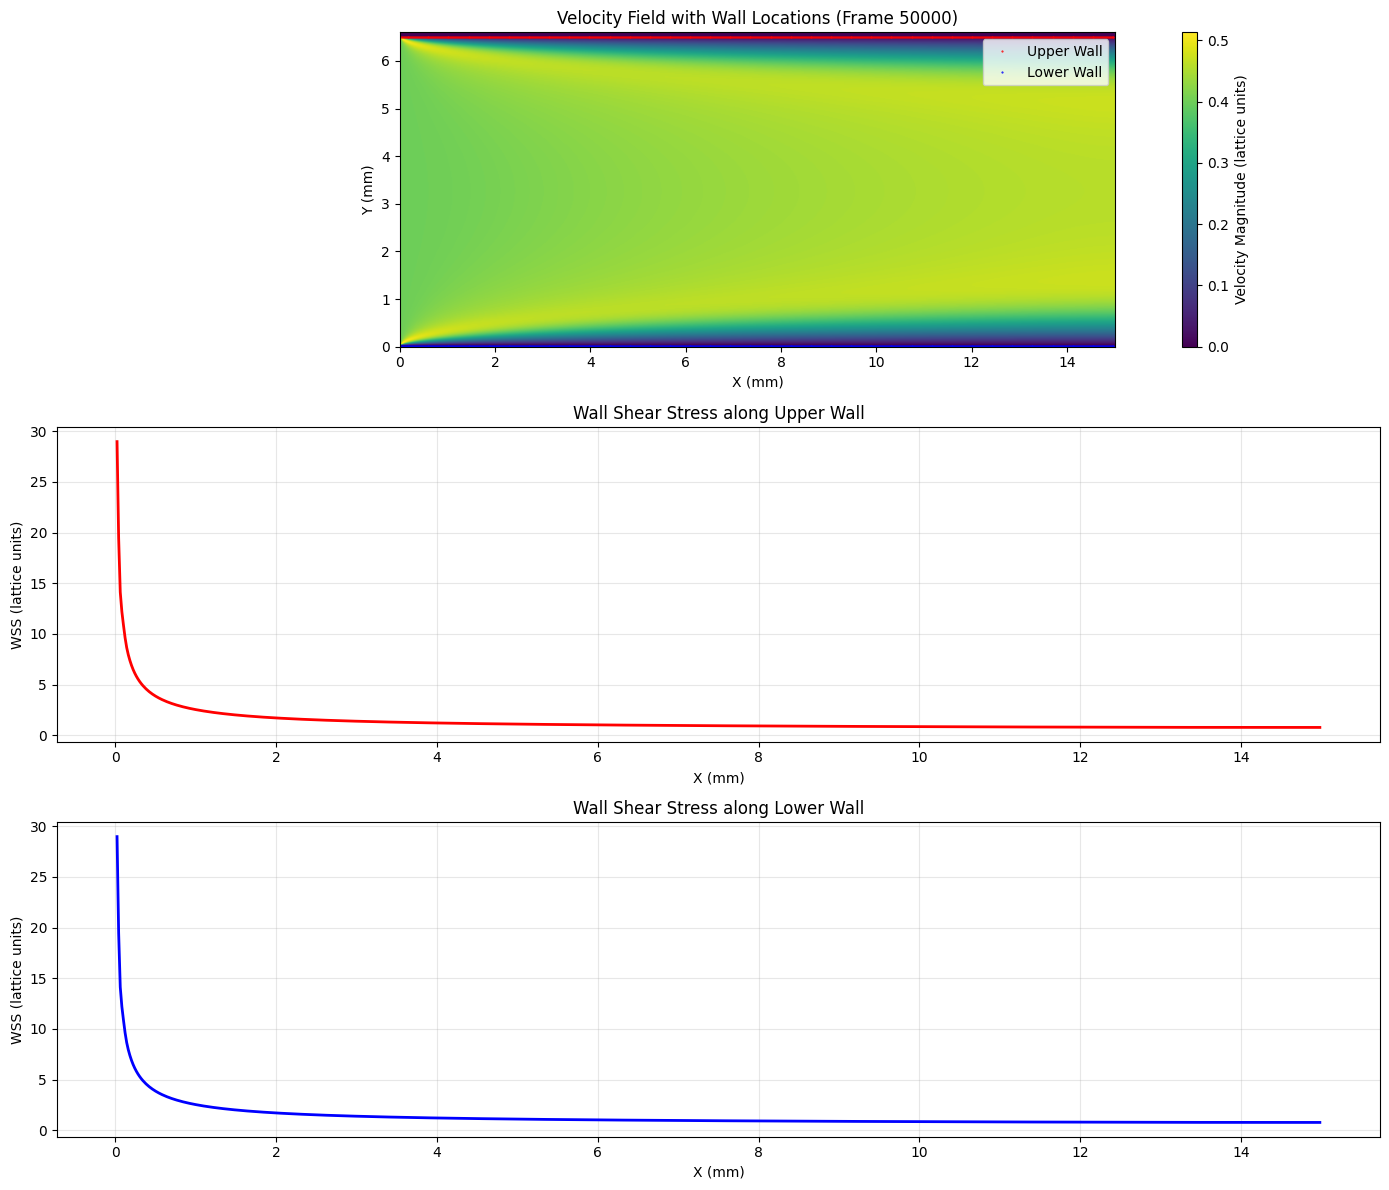


Wall Shear Stress Statistics:
Upper Wall - Mean: 1.366875, Max: 28.963290, Std: 1.678253
Lower Wall - Mean: 1.366875, Max: 28.963298, Std: 1.678253
Overall - Mean: 1.366875, Max: 28.963298

Entry Region:
  Upper Wall - Mean: 3.036019, Max: 28.963290
  Lower Wall - Mean: 3.036018, Max: 28.963298

Middle Region:
  Upper Wall - Mean: 0.960433, Max: 1.039439
  Lower Wall - Mean: 0.960433, Max: 1.039426

Exit Region:
  Upper Wall - Mean: 0.798228, Max: 0.817574
  Lower Wall - Mean: 0.798228, Max: 0.817569


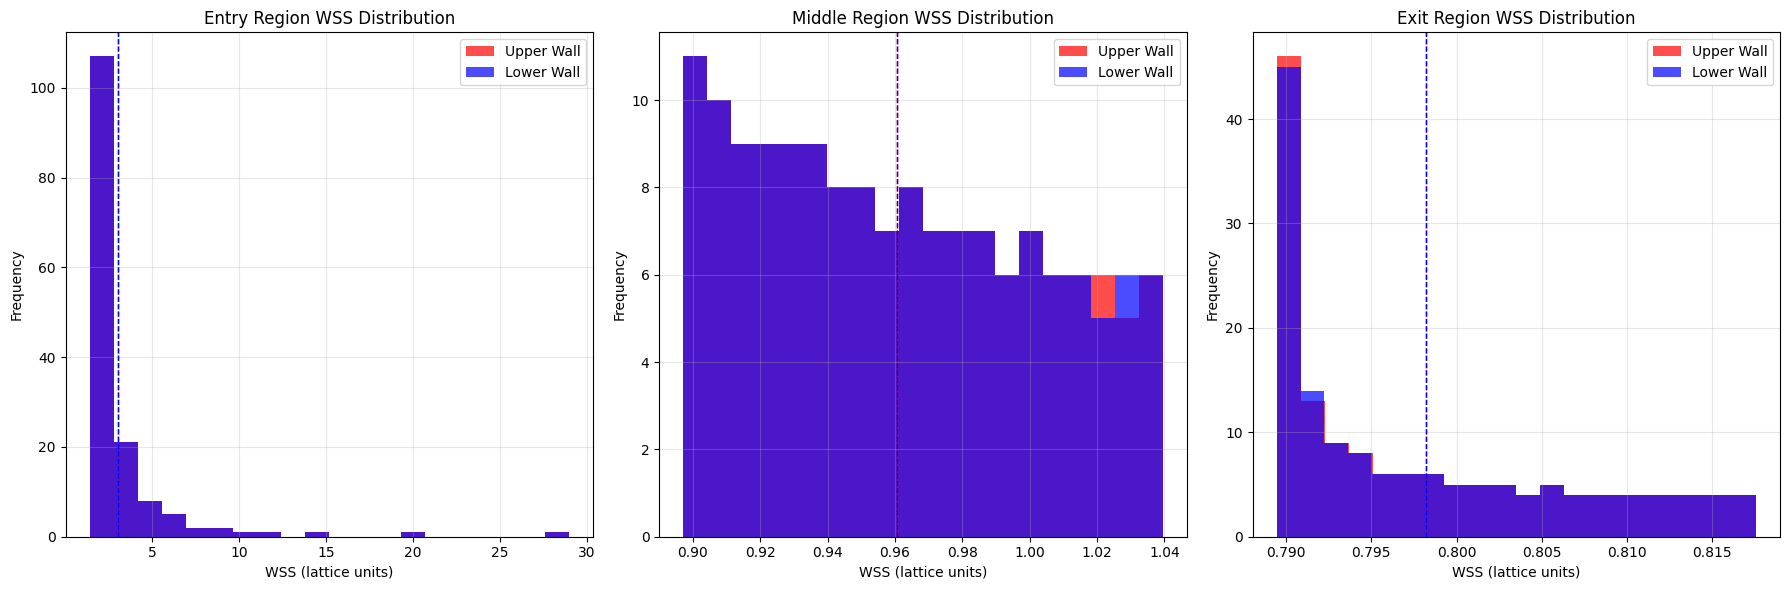


Analyzing wall shear stress distribution for maximum velocity frame 3000...


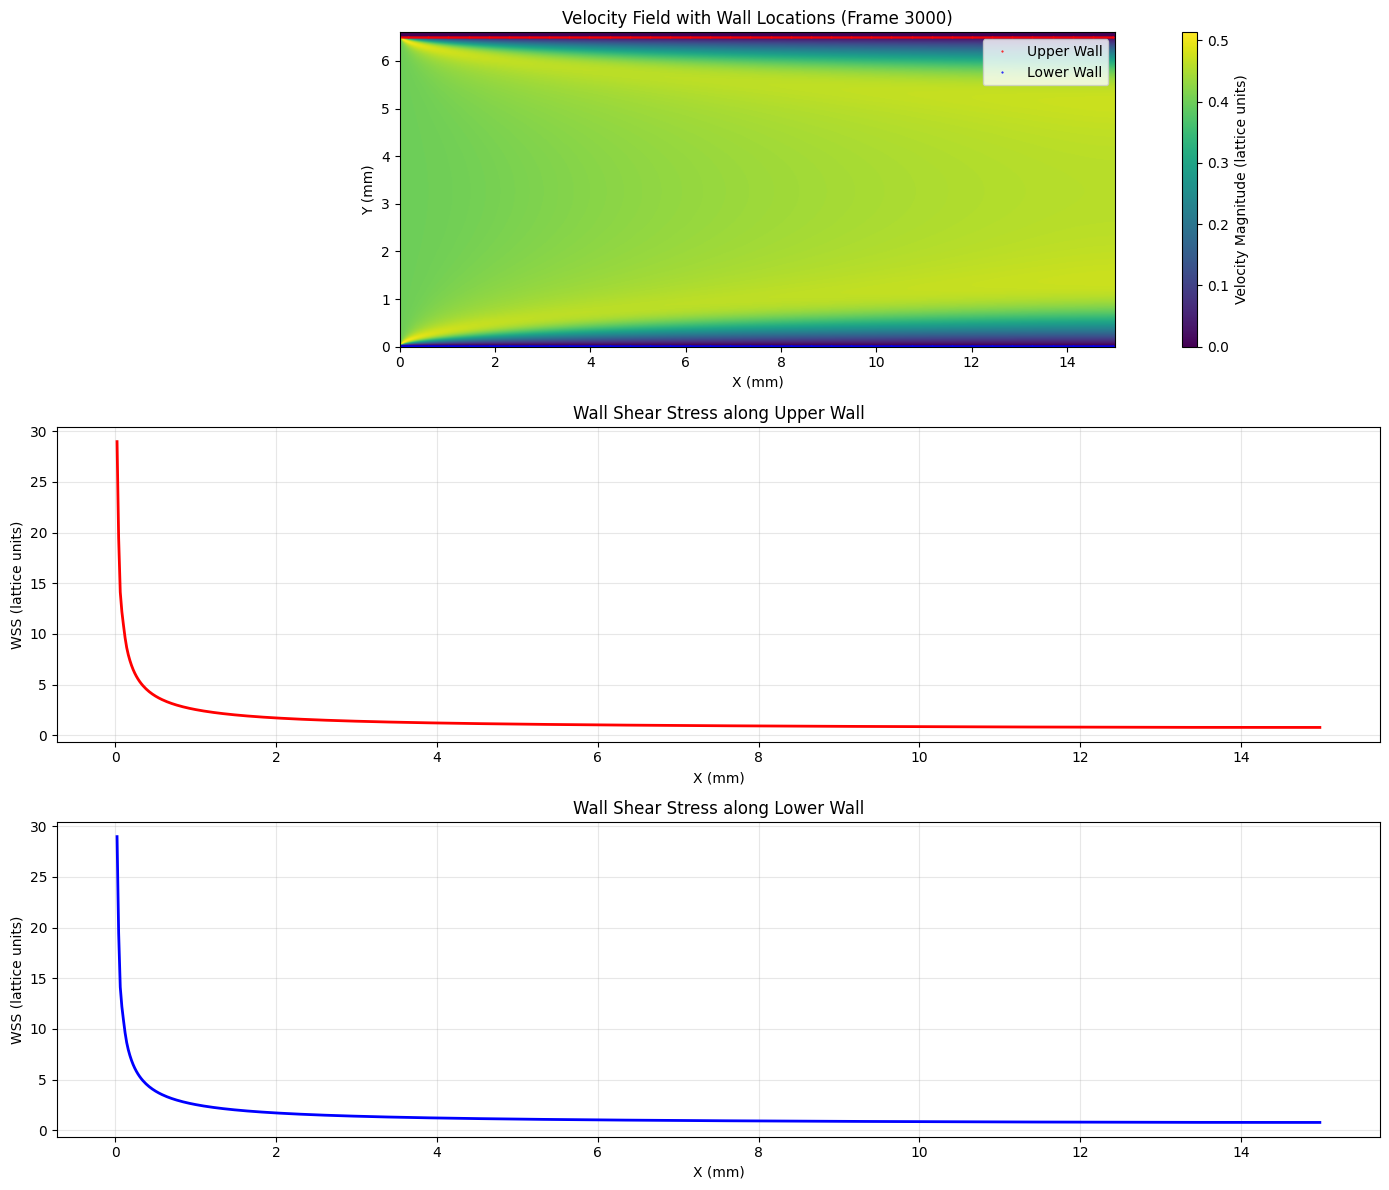


Wall Shear Stress Statistics:
Upper Wall - Mean: 1.366889, Max: 28.963298, Std: 1.678250
Lower Wall - Mean: 1.366889, Max: 28.963282, Std: 1.678249
Overall - Mean: 1.366889, Max: 28.963298

Entry Region:
  Upper Wall - Mean: 3.036024, Max: 28.963298
  Lower Wall - Mean: 3.036024, Max: 28.963282

Middle Region:
  Upper Wall - Mean: 0.960452, Max: 1.039446
  Lower Wall - Mean: 0.960452, Max: 1.039462

Exit Region:
  Upper Wall - Mean: 0.798242, Max: 0.817586
  Lower Wall - Mean: 0.798244, Max: 0.817582


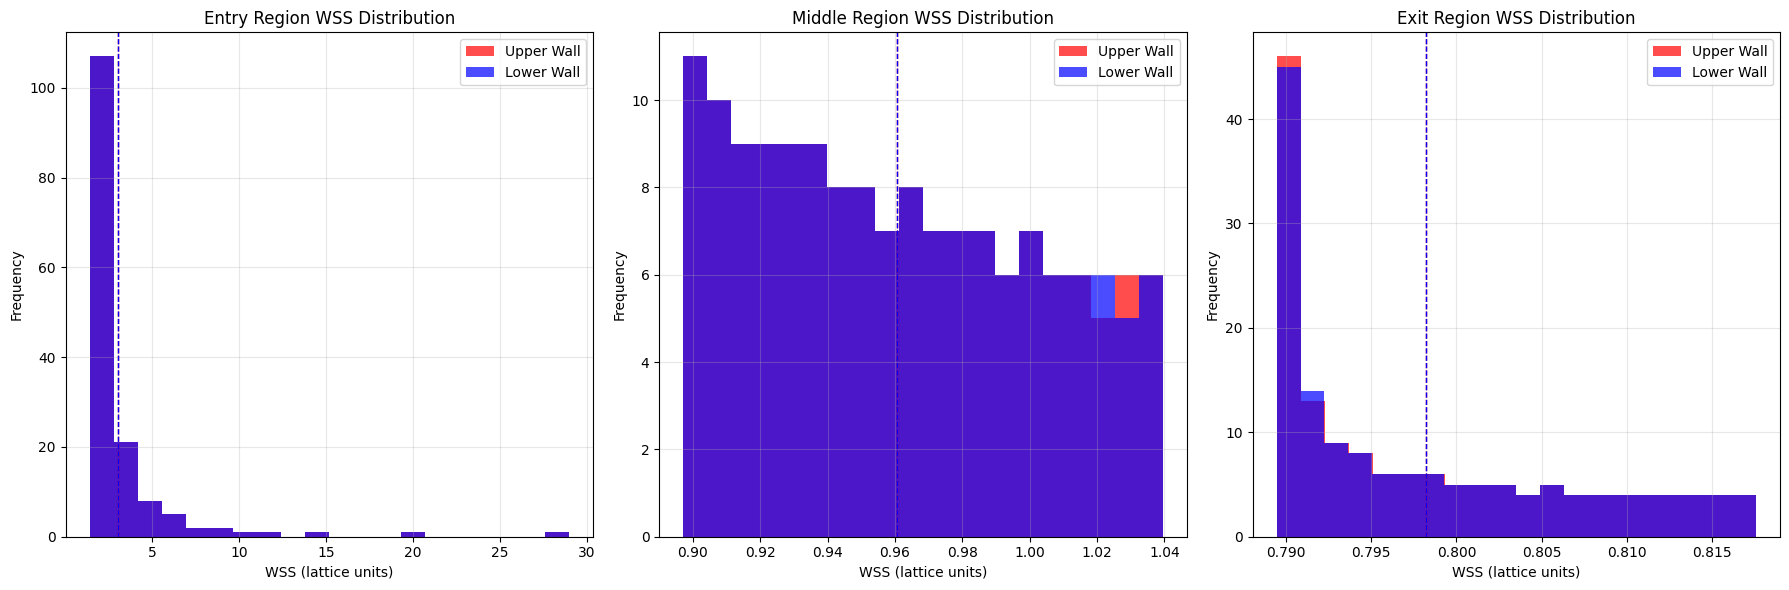

In [8]:
def analyze_pipe_wss(velocity_data, wss_data, frame_idx=50):
    """Analyze wall shear stress distribution along the pipe walls"""
    if velocity_data is None or wss_data is None:
        print("Missing velocity or WSS data")
        return
    
    # Extract frame data
    frame_numbers = velocity_data.get('frame_numbers')
    u_magnitude = velocity_data.get('u_magnitude')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if frame_numbers is None or u_magnitude is None or wss_magnitude is None:
        print("Missing required data components")
        return
    
    # Ensure frame_idx is valid
    if frame_idx >= len(u_magnitude):
        frame_idx = len(u_magnitude) // 2
        print(f"Frame index out of range. Using frame {frame_idx} instead.")
    
    # Get data for the specified frame
    frame_num = frame_numbers[frame_idx]
    frame_u_mag = u_magnitude[frame_idx]
    frame_wss_mag = wss_magnitude[frame_idx]
    
    # Get dimensions
    ny, nx = frame_u_mag.shape
    
    # Get physical units
    dx = pipe_zh_bgk_key_params.get('dx', 2e-5)
    dt = pipe_zh_bgk_key_params.get('dt', 1e-5)
    
    # Get vessel parameters
    if pipe_zh_bgk_parameters is not None:
        vessel_centre_lu = pipe_zh_bgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2)
    else:
        vessel_centre_lu = ny // 2
    
    # Find the upper and lower walls by detecting non-zero WSS values
    upper_wall_indices = []
    lower_wall_indices = []
    
    for x in range(nx):
        # Find wall cells in this column (non-zero WSS)
        wall_indices = np.where(frame_wss_mag[:, x] > 0)[0]
        
        if len(wall_indices) > 0:
            # Separate upper and lower walls based on vessel center
            upper_indices = wall_indices[wall_indices > vessel_centre_lu]
            lower_indices = wall_indices[wall_indices < vessel_centre_lu]
            
            # Take the innermost wall cells (closest to the lumen)
            if len(upper_indices) > 0:
                upper_wall_indices.append((x, upper_indices.min()))
            if len(lower_indices) > 0:
                lower_wall_indices.append((x, lower_indices.max()))
    
    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # 1. Plot velocity field with wall locations marked
    im1 = ax1.imshow(frame_u_mag, cmap='viridis', origin='lower',
                   extent=[0, nx*dx*1000, 0, ny*dx*1000])
    
    # Mark the detected wall positions
    if upper_wall_indices:
        upper_x = [x[0] for x in upper_wall_indices]
        upper_y = [x[1] for x in upper_wall_indices]
        ax1.plot(np.array(upper_x)*dx*1000, np.array(upper_y)*dx*1000, 'r.', markersize=1, label='Upper Wall')
    
    if lower_wall_indices:
        lower_x = [x[0] for x in lower_wall_indices]
        lower_y = [x[1] for x in lower_wall_indices]
        ax1.plot(np.array(lower_x)*dx*1000, np.array(lower_y)*dx*1000, 'b.', markersize=1, label='Lower Wall')
    
    ax1.set_title(f'Velocity Field with Wall Locations (Frame {frame_num})')
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    ax1.legend()
    fig.colorbar(im1, ax=ax1, label='Velocity Magnitude (lattice units)')
    
    # 2. Plot WSS along the upper wall
    if upper_wall_indices:
        upper_x_mm = np.array([x[0] for x in upper_wall_indices]) * dx * 1000
        upper_wss = np.array([frame_wss_mag[y, x] for x, y in upper_wall_indices])
        
        ax2.plot(upper_x_mm, upper_wss, 'r-', linewidth=2)
        ax2.set_title('Wall Shear Stress along Upper Wall')
        ax2.set_xlabel('X (mm)')
        ax2.set_ylabel('WSS (lattice units)')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No upper wall data available', 
                horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    # 3. Plot WSS along the lower wall
    if lower_wall_indices:
        lower_x_mm = np.array([x[0] for x in lower_wall_indices]) * dx * 1000
        lower_wss = np.array([frame_wss_mag[y, x] for x, y in lower_wall_indices])
        
        ax3.plot(lower_x_mm, lower_wss, 'b-', linewidth=2)
        ax3.set_title('Wall Shear Stress along Lower Wall')
        ax3.set_xlabel('X (mm)')
        ax3.set_ylabel('WSS (lattice units)')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No lower wall data available', 
                horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate WSS statistics
    if upper_wall_indices and lower_wall_indices:
        upper_wss = np.array([frame_wss_mag[y, x] for x, y in upper_wall_indices])
        lower_wss = np.array([frame_wss_mag[y, x] for x, y in lower_wall_indices])
        
        print("\nWall Shear Stress Statistics:")
        print(f"Upper Wall - Mean: {upper_wss.mean():.6f}, Max: {upper_wss.max():.6f}, Std: {upper_wss.std():.6f}")
        print(f"Lower Wall - Mean: {lower_wss.mean():.6f}, Max: {lower_wss.max():.6f}, Std: {lower_wss.std():.6f}")
        print(f"Overall - Mean: {np.concatenate([upper_wss, lower_wss]).mean():.6f}, "
              f"Max: {max(upper_wss.max(), lower_wss.max()):.6f}")
        
        # Also create a comparison plot for entry, middle, and exit regions
        entry_region = int(nx * 0.2)    # First 20% of the pipe
        middle_region = int(nx * 0.5)   # Middle of the pipe
        exit_region = int(nx * 0.8)     # Last 20% of the pipe
        
        regions = {
            'Entry': (0, entry_region),
            'Middle': (middle_region - int(nx * 0.1), middle_region + int(nx * 0.1)),
            'Exit': (exit_region, nx-1)
        }
        
        # Create region comparison plot
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        for i, (region_name, (start_x, end_x)) in enumerate(regions.items()):
            # Filter upper and lower wall indices for this region
            region_upper = [(x, y) for x, y in upper_wall_indices if start_x <= x <= end_x]
            region_lower = [(x, y) for x, y in lower_wall_indices if start_x <= x <= end_x]
            
            if region_upper and region_lower:
                region_upper_wss = np.array([frame_wss_mag[y, x] for x, y in region_upper])
                region_lower_wss = np.array([frame_wss_mag[y, x] for x, y in region_lower])
                
                # Plot WSS distribution as a histogram
                axs[i].hist(region_upper_wss, bins=20, alpha=0.7, label='Upper Wall', color='red')
                axs[i].hist(region_lower_wss, bins=20, alpha=0.7, label='Lower Wall', color='blue')
                axs[i].set_title(f'{region_name} Region WSS Distribution')
                axs[i].set_xlabel('WSS (lattice units)')
                axs[i].set_ylabel('Frequency')
                axs[i].legend()
                axs[i].grid(True, alpha=0.3)
                
                # Add mean lines
                axs[i].axvline(region_upper_wss.mean(), color='red', linestyle='--', linewidth=1)
                axs[i].axvline(region_lower_wss.mean(), color='blue', linestyle='--', linewidth=1)
                
                # Print statistics for this region
                print(f"\n{region_name} Region:")
                print(f"  Upper Wall - Mean: {region_upper_wss.mean():.6f}, Max: {region_upper_wss.max():.6f}")
                print(f"  Lower Wall - Mean: {region_lower_wss.mean():.6f}, Max: {region_lower_wss.max():.6f}")
            else:
                axs[i].text(0.5, 0.5, f'No {region_name.lower()} region data', 
                          horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
        
        plt.tight_layout()
        plt.show()
        
        return upper_wall_indices, lower_wall_indices, upper_wss, lower_wss
    
    return None, None, None, None

# Analyze WSS distribution for the middle frame of the simulation
try:
    middle_frame = len(pipe_zh_bgk_velocity['frame_numbers']) // 2
    print(f"\nAnalyzing wall shear stress distribution for middle frame {pipe_zh_bgk_velocity['frame_numbers'][middle_frame]}...")
    upper_wall, lower_wall, upper_wss, lower_wss = analyze_pipe_wss(pipe_zh_bgk_velocity, pipe_zh_bgk_wss, 
                                                                   frame_idx=middle_frame)
    
    # Also analyze the frame with maximum velocity
    max_velocities = np.array([frame.max() for frame in pipe_zh_bgk_velocity['u_magnitude']])
    max_velocity_frame = np.argmax(max_velocities)
    if max_velocity_frame != middle_frame:  # Only do this if it's different from the middle frame
        print(f"\nAnalyzing wall shear stress distribution for maximum velocity frame {pipe_zh_bgk_velocity['frame_numbers'][max_velocity_frame]}...")
        analyze_pipe_wss(pipe_zh_bgk_velocity, pipe_zh_bgk_wss, frame_idx=max_velocity_frame)
except Exception as e:
    print(f"Error analyzing pipe wall shear stress: {e}")
    import traceback
    traceback.print_exc()

## Analyze Wall Shear Stress Evolution Over Time

This section investigates how the wall shear stress changes throughout the simulation by calculating and plotting the average WSS values for each time frame, comparing the Non-Newtonian BGK (TD-ZH) and standard BGK (TD-ZH) models.

Loading TD-ZH BGK velocity data...

Loading velocity data for Pipe TD-ZH BGK...
Found 101 frames, range: 0 to 100000
Loaded u_x data with shape: (101, 330, 751)
Loaded u_x data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_y data with shape: (101, 330, 751)
Loaded u_magnitude data with shape: (101, 330, 751)
Grid dimensions: [752 331   1]
Data loaded in 1.97 seconds
Loading TD-ZH BGK WSS data...

Loading WSS data for Pipe TD-ZH BGK...
Loaded u_magnitude data with shape: (101, 330, 751)
Grid dimensions: [752 331   1]
Data loaded in 1.97 seconds
Loading TD-ZH BGK WSS data...

Loading WSS data for Pipe TD-ZH BGK...
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_x data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_y data with shape: (101, 330, 751)
Loaded wss_magnitude data with shape: (101, 330, 751)
WSS data loaded in 1.15 seconds

Analyzing wall shear stress evolution for both Non-Newtonian BGK (TD-ZH) a

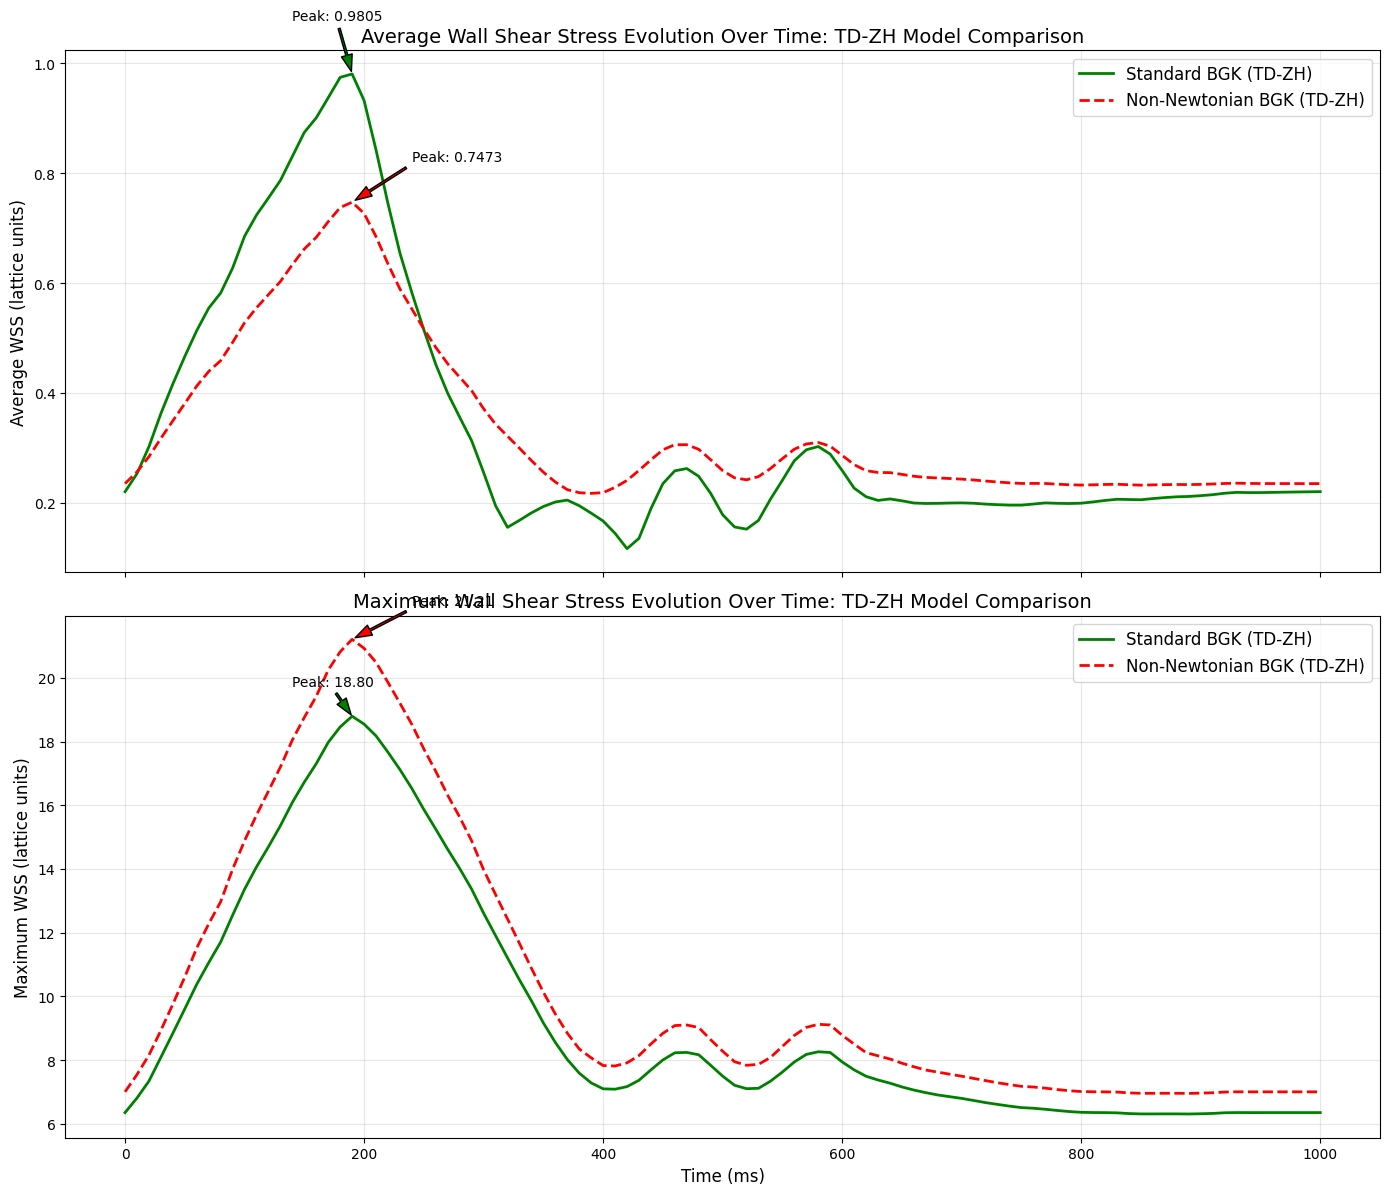


Comparative WSS Statistics (TD-ZH Models):
----------------------------------------------------------------------
Model                     Avg WSS Mean    Avg WSS Max     Max WSS Mean    Max WSS Max    
----------------------------------------------------------------------
Standard BGK (TD-ZH)      0.329649      0.980467      9.291872      18.795811
Non-Newtonian BGK (TD-ZH) 0.333122      0.747321      10.317338      21.210300

Percent Differences (Non-Newtonian relative to Standard TD-ZH):
Average WSS Mean: 1.05%
Average WSS Peak: -23.78%
Maximum WSS Mean: 11.04%
Maximum WSS Peak: 12.85%


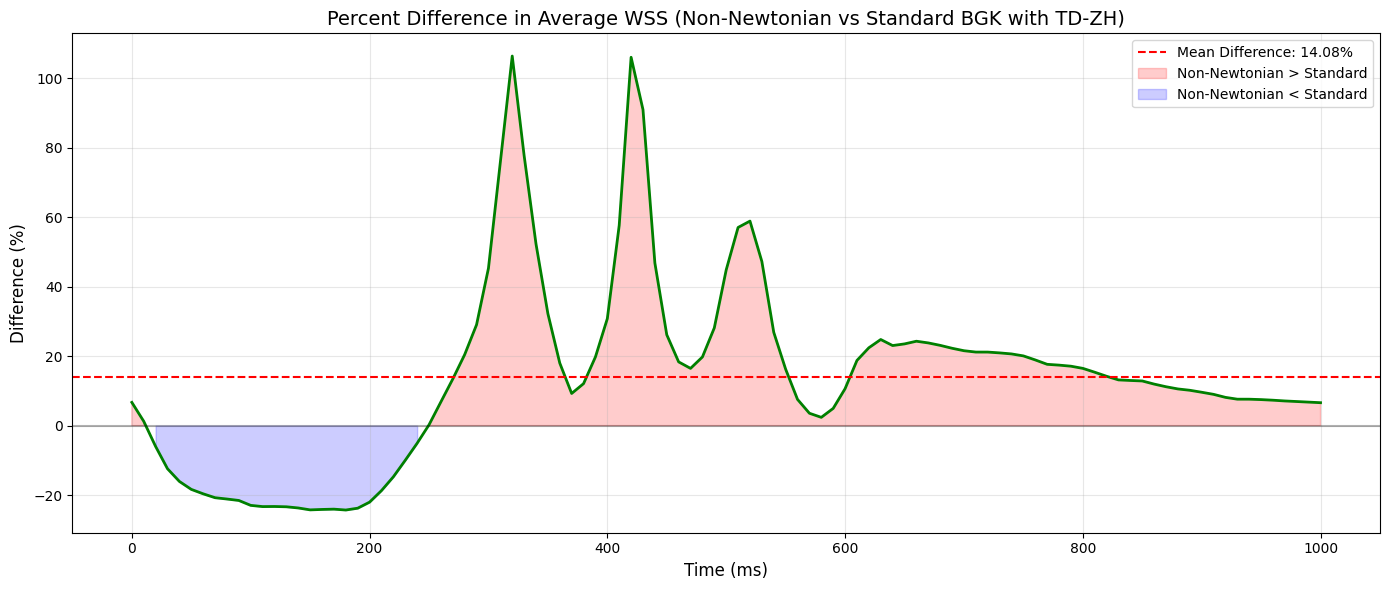

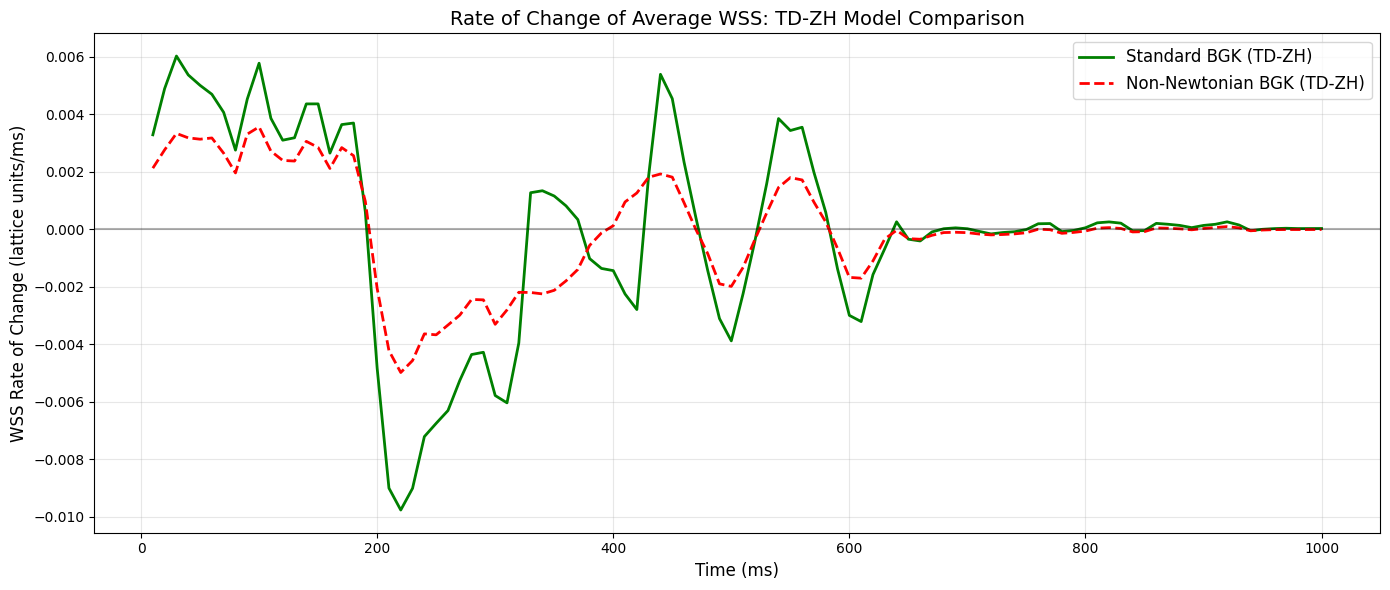

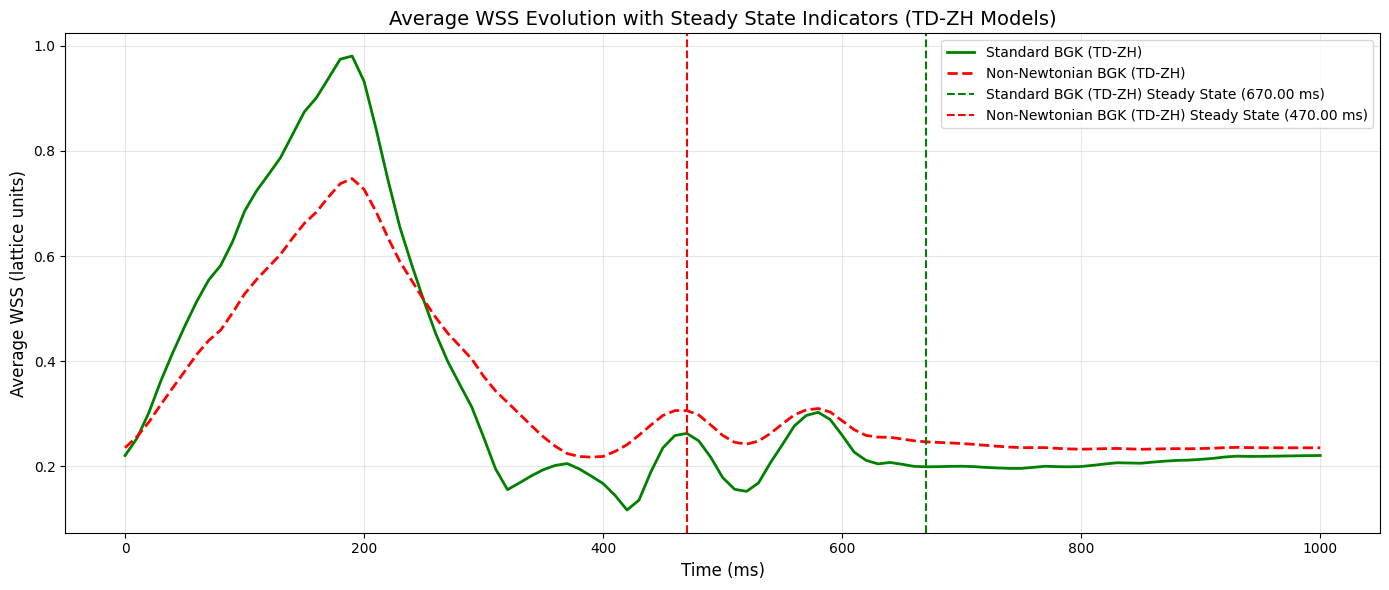


Steady State Analysis (TD-ZH Models):
Standard BGK (TD-ZH) reaches steady state at approximately 670.00 ms
Non-Newtonian BGK (TD-ZH) reaches steady state at approximately 470.00 ms
Time to reach steady state difference: -29.85%


In [9]:
def analyze_wss_evolution(velocity_data, wss_data, simulation_name):
    """Analyze how wall shear stress evolves over time for a simulation.
    
    Args:
        velocity_data (dict): Dictionary containing velocity components and metadata
        wss_data (dict): Dictionary containing WSS components and metadata
        simulation_name (str): Name of the simulation for display purposes
    """
    if velocity_data is None or wss_data is None:
        print(f"Missing data for {simulation_name}")
        return None
    
    # Extract relevant data
    frame_numbers = velocity_data.get('frame_numbers')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if frame_numbers is None or wss_magnitude is None:
        print(f"Missing required data components for {simulation_name}")
        return None
    
    # Calculate average WSS for each frame
    avg_wss_per_frame = []
    max_wss_per_frame = []
    num_frames = len(frame_numbers)
    
    print(f"Calculating WSS statistics for {num_frames} frames...")
    
    for frame_idx in range(num_frames):
        frame_wss = wss_magnitude[frame_idx]
        # Only consider non-zero WSS values (at the walls)
        non_zero_mask = frame_wss > 0
        
        if np.any(non_zero_mask):
            avg_wss = frame_wss[non_zero_mask].mean()
            max_wss = frame_wss.max()
        else:
            avg_wss = 0
            max_wss = 0
        
        avg_wss_per_frame.append(avg_wss)
        max_wss_per_frame.append(max_wss)
    
    # Convert to numpy arrays for easier manipulation
    avg_wss_per_frame = np.array(avg_wss_per_frame)
    max_wss_per_frame = np.array(max_wss_per_frame)
    
    # Calculate time in milliseconds
    dt = pipe_zh_bgk_key_params.get('dt', 1e-5)  # seconds
    time_ms = frame_numbers * dt * 1000  # convert to milliseconds
    
    return {
        'time_ms': time_ms,
        'avg_wss': avg_wss_per_frame,
        'max_wss': max_wss_per_frame
    }

# First, load the TD-ZH BGK data if not already loaded
if 'pipe_tdzh_bgk_velocity' not in globals() or pipe_tdzh_bgk_velocity is None:
    print("Loading TD-ZH BGK velocity data...")
    pipe_tdzh_bgk_velocity = load_velocity_data(pipe_tdzh_bgk_folder, "Pipe TD-ZH BGK")

if 'pipe_tdzh_bgk_wss' not in globals() or pipe_tdzh_bgk_wss is None:
    print("Loading TD-ZH BGK WSS data...")
    pipe_tdzh_bgk_wss = load_wss_data(pipe_tdzh_bgk_folder, "Pipe TD-ZH BGK")

# Now analyze both TD-ZH models for comparison
print("\nAnalyzing wall shear stress evolution for both Non-Newtonian BGK (TD-ZH) and standard BGK (TD-ZH) models...")

# Calculate WSS evolution for TD-ZH BGK model (standard BGK with time-dependent boundary conditions)
tdzh_bgk_wss_evolution = analyze_wss_evolution(pipe_tdzh_bgk_velocity, pipe_tdzh_bgk_wss, "TD-ZH BGK")

# Calculate WSS evolution for TD-ZH NNBGK model (non-Newtonian BGK with time-dependent boundary conditions)
nn_bgk_wss_evolution = analyze_wss_evolution(pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss, "Non-Newtonian BGK (TD-ZH)")

if tdzh_bgk_wss_evolution is not None and nn_bgk_wss_evolution is not None:
    # Create comparison plots with both models
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    # Plot average WSS over time for both models
    ax1.plot(tdzh_bgk_wss_evolution['time_ms'], tdzh_bgk_wss_evolution['avg_wss'], 'g-', linewidth=2, label='Standard BGK (TD-ZH)')
    ax1.plot(nn_bgk_wss_evolution['time_ms'], nn_bgk_wss_evolution['avg_wss'], 'r--', linewidth=2, label='Non-Newtonian BGK (TD-ZH)')
    ax1.set_title('Average Wall Shear Stress Evolution Over Time: TD-ZH Model Comparison', fontsize=14)
    ax1.set_ylabel('Average WSS (lattice units)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)
    
    # Add annotations for peak values
    std_peak_idx = np.argmax(tdzh_bgk_wss_evolution['avg_wss'])
    nn_peak_idx = np.argmax(nn_bgk_wss_evolution['avg_wss'])
    
    std_peak_time = tdzh_bgk_wss_evolution['time_ms'][std_peak_idx]
    std_peak_val = tdzh_bgk_wss_evolution['avg_wss'][std_peak_idx]
    
    nn_peak_time = nn_bgk_wss_evolution['time_ms'][nn_peak_idx]
    nn_peak_val = nn_bgk_wss_evolution['avg_wss'][nn_peak_idx]
    
    ax1.annotate(f'Peak: {std_peak_val:.4f}',
                xy=(std_peak_time, std_peak_val),
                xytext=(std_peak_time-50, std_peak_val*1.1),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)
    
    ax1.annotate(f'Peak: {nn_peak_val:.4f}',
                xy=(nn_peak_time, nn_peak_val),
                xytext=(nn_peak_time+50, nn_peak_val*1.1),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)
    
    # Plot maximum WSS over time for both models
    ax2.plot(tdzh_bgk_wss_evolution['time_ms'], tdzh_bgk_wss_evolution['max_wss'], 'g-', linewidth=2, label='Standard BGK (TD-ZH)')
    ax2.plot(nn_bgk_wss_evolution['time_ms'], nn_bgk_wss_evolution['max_wss'], 'r--', linewidth=2, label='Non-Newtonian BGK (TD-ZH)')
    ax2.set_title('Maximum Wall Shear Stress Evolution Over Time: TD-ZH Model Comparison', fontsize=14)
    ax2.set_xlabel('Time (ms)', fontsize=12)
    ax2.set_ylabel('Maximum WSS (lattice units)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)
    
    # Add annotations for max WSS peaks
    std_max_peak_idx = np.argmax(tdzh_bgk_wss_evolution['max_wss'])
    nn_max_peak_idx = np.argmax(nn_bgk_wss_evolution['max_wss'])
    
    std_max_peak_time = tdzh_bgk_wss_evolution['time_ms'][std_max_peak_idx]
    std_max_peak_val = tdzh_bgk_wss_evolution['max_wss'][std_max_peak_idx]
    
    nn_max_peak_time = nn_bgk_wss_evolution['time_ms'][nn_max_peak_idx]
    nn_max_peak_val = nn_bgk_wss_evolution['max_wss'][nn_max_peak_idx]
    
    ax2.annotate(f'Peak: {std_max_peak_val:.2f}',
                xy=(std_max_peak_time, std_max_peak_val),
                xytext=(std_max_peak_time-50, std_max_peak_val*1.05),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)
    
    ax2.annotate(f'Peak: {nn_max_peak_val:.2f}',
                xy=(nn_max_peak_time, nn_max_peak_val),
                xytext=(nn_max_peak_time+50, nn_max_peak_val*1.05),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics for both models
    tdzh_avg_wss = tdzh_bgk_wss_evolution['avg_wss']
    tdzh_max_wss = tdzh_bgk_wss_evolution['max_wss']
    nn_avg_wss = nn_bgk_wss_evolution['avg_wss']
    nn_max_wss = nn_bgk_wss_evolution['max_wss']
    
    print("\nComparative WSS Statistics (TD-ZH Models):")
    print("-" * 70)
    print(f"{'Model':<25} {'Avg WSS Mean':<15} {'Avg WSS Max':<15} {'Max WSS Mean':<15} {'Max WSS Max':<15}")
    print("-" * 70)
    print(f"{'Standard BGK (TD-ZH)':<25} {np.mean(tdzh_avg_wss):.6f}      {np.max(tdzh_avg_wss):.6f}      {np.mean(tdzh_max_wss):.6f}      {np.max(tdzh_max_wss):.6f}")
    print(f"{'Non-Newtonian BGK (TD-ZH)':<25} {np.mean(nn_avg_wss):.6f}      {np.max(nn_avg_wss):.6f}      {np.mean(nn_max_wss):.6f}      {np.max(nn_max_wss):.6f}")
    
    # Calculate percent differences
    avg_wss_mean_diff = 100 * (np.mean(nn_avg_wss) - np.mean(tdzh_avg_wss)) / np.mean(tdzh_avg_wss)
    avg_wss_peak_diff = 100 * (np.max(nn_avg_wss) - np.max(tdzh_avg_wss)) / np.max(tdzh_avg_wss)
    max_wss_mean_diff = 100 * (np.mean(nn_max_wss) - np.mean(tdzh_max_wss)) / np.mean(tdzh_max_wss)
    max_wss_peak_diff = 100 * (np.max(nn_max_wss) - np.max(tdzh_max_wss)) / np.max(tdzh_max_wss)
    
    print("\nPercent Differences (Non-Newtonian relative to Standard TD-ZH):")
    print(f"Average WSS Mean: {avg_wss_mean_diff:.2f}%")
    print(f"Average WSS Peak: {avg_wss_peak_diff:.2f}%")
    print(f"Maximum WSS Mean: {max_wss_mean_diff:.2f}%")
    print(f"Maximum WSS Peak: {max_wss_peak_diff:.2f}%")
    
    # Create a plot showing the percent difference over time
    plt.figure(figsize=(14, 6))
    if len(tdzh_bgk_wss_evolution['time_ms']) == len(nn_bgk_wss_evolution['time_ms']):
        percent_diff = 100 * (nn_bgk_wss_evolution['avg_wss'] - tdzh_bgk_wss_evolution['avg_wss']) / tdzh_bgk_wss_evolution['avg_wss']
        plt.plot(tdzh_bgk_wss_evolution['time_ms'], percent_diff, 'g-', linewidth=2)
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axhline(y=percent_diff.mean(), color='r', linestyle='--', 
                   label=f'Mean Difference: {percent_diff.mean():.2f}%')
        
        # Shade regions based on whether NN-BGK is higher or lower than standard BGK
        plt.fill_between(tdzh_bgk_wss_evolution['time_ms'], 0, percent_diff, 
                        where=(percent_diff > 0), color='red', alpha=0.2, 
                        label='Non-Newtonian > Standard')
        plt.fill_between(tdzh_bgk_wss_evolution['time_ms'], 0, percent_diff, 
                        where=(percent_diff < 0), color='blue', alpha=0.2, 
                        label='Non-Newtonian < Standard')
    
    plt.title('Percent Difference in Average WSS (Non-Newtonian vs Standard BGK with TD-ZH)', fontsize=14)
    plt.xlabel('Time (ms)', fontsize=12)
    plt.ylabel('Difference (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot rate of change for both models
    if len(tdzh_avg_wss) > 1 and len(nn_avg_wss) > 1:
        # Calculate rates of change
        tdzh_wss_diff = np.diff(tdzh_avg_wss)
        nn_wss_diff = np.diff(nn_avg_wss)
        time_diff = np.diff(tdzh_bgk_wss_evolution['time_ms'])
        tdzh_wss_rate = tdzh_wss_diff / time_diff
        nn_wss_rate = nn_wss_diff / time_diff
        
        # Create side-by-side comparison of rate of change
        plt.figure(figsize=(14, 6))
        plt.plot(tdzh_bgk_wss_evolution['time_ms'][1:], tdzh_wss_rate, 'g-', linewidth=2, label='Standard BGK (TD-ZH)')
        plt.plot(nn_bgk_wss_evolution['time_ms'][1:], nn_wss_rate, 'r--', linewidth=2, label='Non-Newtonian BGK (TD-ZH)')
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.title('Rate of Change of Average WSS: TD-ZH Model Comparison', fontsize=14)
        plt.xlabel('Time (ms)', fontsize=12)
        plt.ylabel('WSS Rate of Change (lattice units/ms)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Identify phases of the simulation based on rate of change
        transient_threshold = 0.0001  # Threshold to consider rate significant
        tdzh_steady_indices = np.where(np.abs(tdzh_wss_rate) < transient_threshold)[0]
        nn_steady_indices = np.where(np.abs(nn_wss_rate) < transient_threshold)[0]
        
        # Plot with highlighted steady-state regions for both models
        plt.figure(figsize=(14, 6))
        plt.plot(tdzh_bgk_wss_evolution['time_ms'], tdzh_avg_wss, 'g-', linewidth=2, label='Standard BGK (TD-ZH)')
        plt.plot(nn_bgk_wss_evolution['time_ms'], nn_avg_wss, 'r--', linewidth=2, label='Non-Newtonian BGK (TD-ZH)')
        
        # Add steady state markers for each model if available
        if len(tdzh_steady_indices) > 0:
            tdzh_first_steady_idx = tdzh_steady_indices[0] + 1
            tdzh_steady_time = tdzh_bgk_wss_evolution['time_ms'][tdzh_first_steady_idx]
            plt.axvline(x=tdzh_steady_time, color='g', linestyle='--', linewidth=1.5,
                       label=f'Standard BGK (TD-ZH) Steady State ({tdzh_steady_time:.2f} ms)')
        
        if len(nn_steady_indices) > 0:
            nn_first_steady_idx = nn_steady_indices[0] + 1
            nn_steady_time = nn_bgk_wss_evolution['time_ms'][nn_first_steady_idx]
            plt.axvline(x=nn_steady_time, color='r', linestyle='--', linewidth=1.5,
                       label=f'Non-Newtonian BGK (TD-ZH) Steady State ({nn_steady_time:.2f} ms)')
        
        plt.title('Average WSS Evolution with Steady State Indicators (TD-ZH Models)', fontsize=14)
        plt.xlabel('Time (ms)', fontsize=12)
        plt.ylabel('Average WSS (lattice units)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Report steady state times
        print("\nSteady State Analysis (TD-ZH Models):")
        if len(tdzh_steady_indices) > 0:
            tdzh_steady_time = tdzh_bgk_wss_evolution['time_ms'][tdzh_steady_indices[0] + 1]
            print(f"Standard BGK (TD-ZH) reaches steady state at approximately {tdzh_steady_time:.2f} ms")
        else:
            print("Standard BGK (TD-ZH) does not reach steady state within the simulation timeframe")
            
        if len(nn_steady_indices) > 0:
            nn_steady_time = nn_bgk_wss_evolution['time_ms'][nn_steady_indices[0] + 1]
            print(f"Non-Newtonian BGK (TD-ZH) reaches steady state at approximately {nn_steady_time:.2f} ms")
        else:
            print("Non-Newtonian BGK (TD-ZH) does not reach steady state within the simulation timeframe")
            
        if len(tdzh_steady_indices) > 0 and len(nn_steady_indices) > 0:
            time_to_steady_diff = 100 * (nn_steady_time - tdzh_steady_time) / tdzh_steady_time
            print(f"Time to reach steady state difference: {time_to_steady_diff:.2f}%")
else:
    print("Could not analyze WSS evolution due to missing data for one or both TD-ZH models.")

## Enhanced Wall Shear Stress Visualization Techniques

This section demonstrates improved methods for visualizing WSS direction and magnitude, which are critical for understanding hemodynamic forces acting on vessel walls.


Creating enhanced WSS direction visualizations for frame 50000...


/tmp/ipykernel_57601/2702156417.py:193: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax3.set_ylim(np.min(lower_y) - buffer, np.max(lower_y) + buffer)


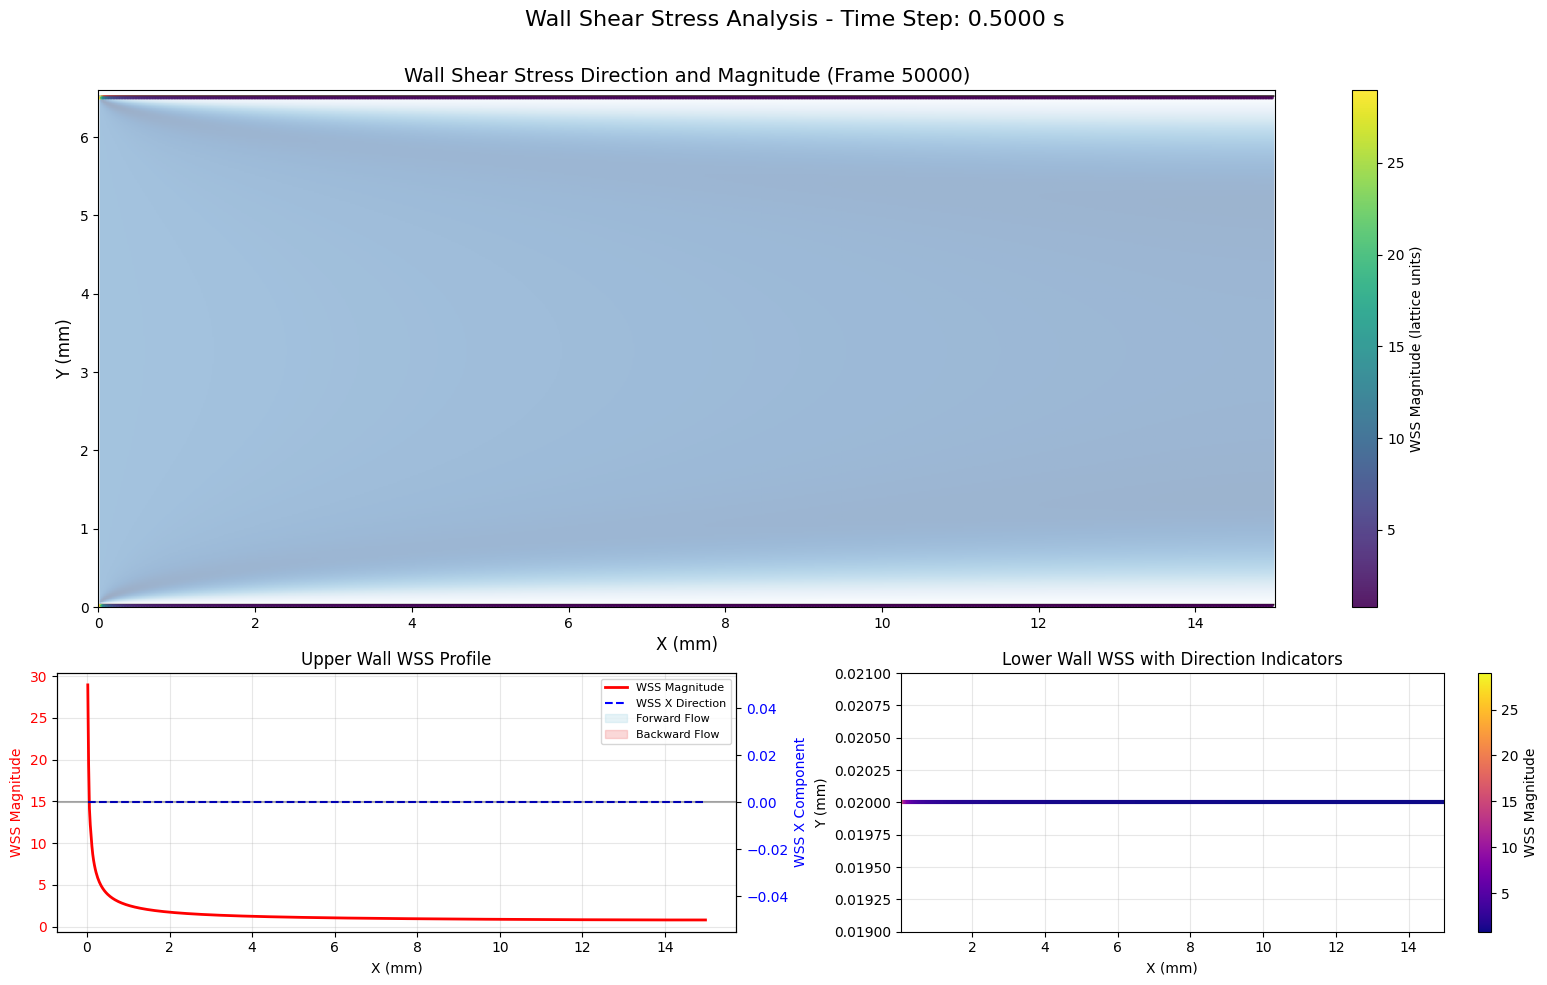


Creating 3D WSS visualization...
Error creating interpolated surface: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Q12 Qz Qc Qt Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1097715548  delaunay  Q12-allow-wide  Qz-infinity-point
  Qcoplanar-keep  Qtriangulate  Qbbound-last  _pre-merge  _zero-centrum
  Qinterior-keep  Pgood  _max-width 15  Error-roundoff 2.1e-14
  _one-merge 1.5e-13  Visible-distance 4.2e-14  U-max-coplanar 4.2e-14
  Width-outside 8.3e-14  _wide-facet 2.5e-13  _maxoutside 1.7e-13

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v4):  0.04   6.5 7.2e-05
- p749(v3):   7.5   6.5    15
- p748(v2):    15   6.5    13
- p0(v1):  0.02   6.5     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error 

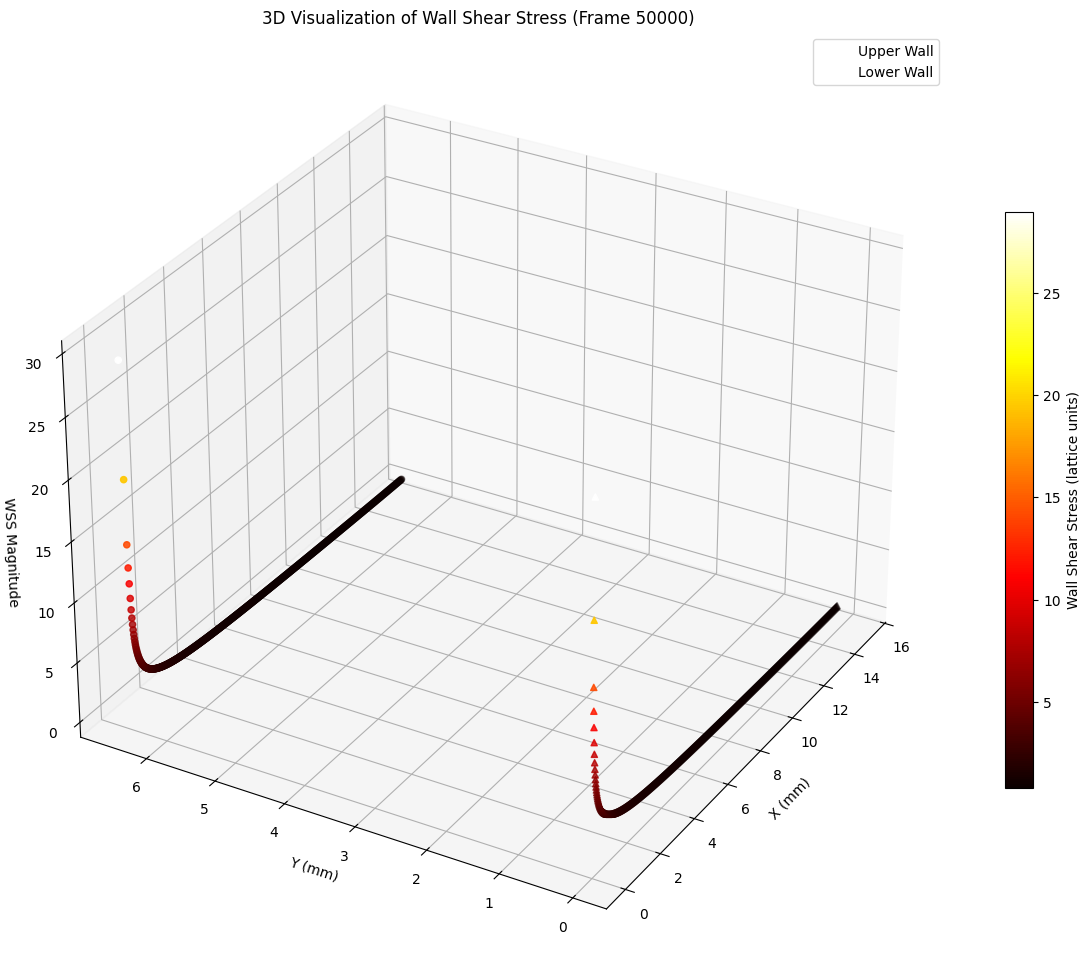

In [10]:
def visualize_wss_directions(velocity_data, wss_data, frame_idx=50, fig_size=(16, 10)):
    """Create enhanced visualizations of wall shear stress direction and magnitude.
    
    Args:
        velocity_data (dict): Dictionary containing velocity components and metadata
        wss_data (dict): Dictionary containing WSS components and metadata
        frame_idx (int): Index of the frame to visualize
        fig_size (tuple): Size of the figure (width, height)
    """
    if velocity_data is None or wss_data is None:
        print("Missing velocity or WSS data for pipe flow")
        return
    
    # Extract frame data
    frame_numbers = velocity_data.get('frame_numbers')
    u_magnitude = velocity_data.get('u_magnitude')
    wss_x = wss_data.get('wss_x')
    wss_y = wss_data.get('wss_y')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if (frame_numbers is None or u_magnitude is None or 
        wss_x is None or wss_y is None or wss_magnitude is None):
        print("Missing required data components")
        return
    
    # Ensure frame_idx is valid
    if frame_idx >= len(u_magnitude):
        frame_idx = len(u_magnitude) // 2
        print(f"Frame index out of range. Using frame {frame_idx} instead.")
    
    # Get data for the specified frame
    frame_num = frame_numbers[frame_idx]
    frame_u_mag = u_magnitude[frame_idx]
    frame_wss_x = wss_x[frame_idx]
    frame_wss_y = wss_y[frame_idx]
    frame_wss_mag = wss_magnitude[frame_idx]
    
    # Get physical dimensions
    ny, nx = frame_u_mag.shape
    dx = pipe_zh_bgk_key_params.get('dx', 2e-5)  # m/lu
    dt = pipe_zh_bgk_key_params.get('dt', 1e-5)  # s/ts
    
    # Get vessel parameters
    if pipe_zh_bgk_parameters is not None:
        vessel_centre_lu = pipe_zh_bgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2)
    else:
        vessel_centre_lu = ny // 2
    
    # Find wall cells (where WSS is non-zero)
    wall_mask = frame_wss_mag > 0
    
    # Extract wall coordinates
    y_coords, x_coords = np.where(wall_mask)
    wss_vectors_x = frame_wss_x[wall_mask]
    wss_vectors_y = frame_wss_y[wall_mask]
    wss_magnitudes = frame_wss_mag[wall_mask]
    
    # Separate upper and lower walls based on vessel center
    upper_wall_mask = y_coords > vessel_centre_lu
    lower_wall_mask = y_coords < vessel_centre_lu
    
    # Convert to physical units (mm) for display
    x_mm = x_coords * dx * 1000  # Convert to mm
    y_mm = y_coords * dx * 1000  # Convert to mm
    
    # Create figure for advanced visualization
    fig = plt.figure(figsize=fig_size)
    
    # Create a grid of subplots
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
    
    # Main WSS vector plot
    ax1 = fig.add_subplot(gs[0, :])
    
    # Create a mask for the vessel walls where WSS is non-zero
    wss_display = np.full_like(frame_wss_mag, np.nan)
    wss_display[wall_mask] = frame_wss_mag[wall_mask]
    
    # Plot velocity magnitude as background
    im_vel = ax1.imshow(frame_u_mag, cmap='Blues', origin='lower',
                     extent=[0, nx*dx*1000, 0, ny*dx*1000], alpha=0.4)
    
    # Plot WSS magnitude as a heatmap
    im_wss = ax1.imshow(wss_display, cmap='hot', origin='lower',
                      extent=[0, nx*dx*1000, 0, ny*dx*1000],
                      vmin=0, vmax=np.nanmax(wss_display)*1.1 if np.any(~np.isnan(wss_display)) else 1)
    
    # Normalize WSS vectors for better visualization
    # Scale the vectors for better visualization
    vector_scale = 5.0
    # Use color to represent magnitude and arrows to show direction
    sc = ax1.quiver(x_mm, y_mm, wss_vectors_x, wss_vectors_y,
                  wss_magnitudes, cmap='viridis',
                  scale=vector_scale, headwidth=3, headlength=4,
                  width=0.003, alpha=0.9)
    
    # Add colorbar for WSS magnitude
    cbar = fig.colorbar(sc, ax=ax1)
    cbar.set_label('WSS Magnitude (lattice units)')
    
    # Set title and labels for WSS plot
    ax1.set_xlabel('X (mm)', fontsize=12)
    ax1.set_ylabel('Y (mm)', fontsize=12)
    ax1.set_title(f'Wall Shear Stress Direction and Magnitude (Frame {frame_num})', fontsize=14)
    
    # WSS tangential plot (option 1) - Upper wall
    ax2 = fig.add_subplot(gs[1, 0])
    
    if np.any(upper_wall_mask):
        upper_x = x_mm[upper_wall_mask]
        upper_wss = wss_magnitudes[upper_wall_mask]
        upper_wss_x = wss_vectors_x[upper_wall_mask]
        
        # Sort by x-coordinate for a coherent line
        sort_idx = np.argsort(upper_x)
        upper_x = upper_x[sort_idx]
        upper_wss = upper_wss[sort_idx]
        upper_wss_x = upper_wss_x[sort_idx]
        
        # Plot WSS magnitude along upper wall
        ax2.plot(upper_x, upper_wss, 'r-', linewidth=2, label='WSS Magnitude')
        
        # Use secondary y-axis for WSS x-component to show directionality
        ax2_twin = ax2.twinx()
        ax2_twin.plot(upper_x, upper_wss_x, 'b--', linewidth=1.5, label='WSS X Direction')
        ax2_twin.set_ylabel('WSS X Component', color='b')
        ax2_twin.tick_params(axis='y', labelcolor='b')
        ax2_twin.axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Zero line for direction
        
        # Color regions based on flow direction for better visualization
        ax2_twin.fill_between(upper_x, 0, upper_wss_x, where=(upper_wss_x > 0),
                            color='lightblue', alpha=0.3, label='Forward Flow')
        ax2_twin.fill_between(upper_x, 0, upper_wss_x, where=(upper_wss_x < 0),
                            color='lightcoral', alpha=0.3, label='Backward Flow')
    else:
        ax2.text(0.5, 0.5, 'No upper wall data available',
                horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    ax2.set_title('Upper Wall WSS Profile', fontsize=12)
    ax2.set_xlabel('X (mm)', fontsize=10)
    ax2.set_ylabel('WSS Magnitude', color='r', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.grid(True, alpha=0.3)
    
    # Add a legend for the upper wall plot
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels() if 'ax2_twin' in locals() else ([], [])
    if lines1 or lines2:
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)
    
    # WSS tangential plot (option 2) - Stream ribbons for lower wall
    ax3 = fig.add_subplot(gs[1, 1])
    
    if np.any(lower_wall_mask):
        lower_x = x_mm[lower_wall_mask]
        lower_y = y_mm[lower_wall_mask]
        lower_wss_x = wss_vectors_x[lower_wall_mask]
        lower_wss_y = wss_vectors_y[lower_wall_mask]
        lower_wss = wss_magnitudes[lower_wall_mask]
        
        # Sort by x-coordinate
        sort_idx = np.argsort(lower_x)
        lower_x = lower_x[sort_idx]
        lower_y = lower_y[sort_idx]
        lower_wss = lower_wss[sort_idx]
        lower_wss_x = lower_wss_x[sort_idx]
        lower_wss_y = lower_wss_y[sort_idx]
        
        # Plot WSS magnitude as colored line
        # Import LineCollection for creating colored line segments
        from matplotlib.collections import LineCollection
        
        points = np.array([lower_x, lower_y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(np.min(lower_wss), np.max(lower_wss))
        lc = LineCollection(segments, cmap='plasma', norm=norm)
        lc.set_array(lower_wss)
        lc.set_linewidth(3)
        line = ax3.add_collection(lc)
        
        # Add colorbar for WSS magnitude
        cbar = fig.colorbar(line, ax=ax3)
        cbar.set_label('WSS Magnitude')
        
        # Add direction indicators using streamlines or arrows
        # For streamlines, we need a grid, so we create a simple one based on the wall path
        ax3.quiver(lower_x[::10], lower_y[::10], lower_wss_x[::10], lower_wss_y[::10], 
                 color='black', scale=2, width=0.004, headwidth=3)
        
        # Set axes limits based on data
        ax3.set_xlim(np.min(lower_x), np.max(lower_x))
        buffer = (np.max(lower_y) - np.min(lower_y)) * 0.2
        ax3.set_ylim(np.min(lower_y) - buffer, np.max(lower_y) + buffer)
    else:
        ax3.text(0.5, 0.5, 'No lower wall data available',
                horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    
    ax3.set_title('Lower Wall WSS with Direction Indicators', fontsize=12)
    ax3.set_xlabel('X (mm)', fontsize=10)
    ax3.set_ylabel('Y (mm)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Add overall title and adjust layout
    plt.suptitle(f'Wall Shear Stress Analysis - Time Step: {frame_num * dt:.4f} s', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

# Also create a 3D WSS visualization function
def visualize_wss_3d(velocity_data, wss_data, frame_idx=50, fig_size=(12, 10)):
    """Create a 3D visualization of Wall Shear Stress magnitude and direction.
    
    Args:
        velocity_data (dict): Dictionary containing velocity components and metadata
        wss_data (dict): Dictionary containing WSS components and metadata
        frame_idx (int): Index of the frame to visualize
        fig_size (tuple): Size of the figure (width, height)
    """
    if velocity_data is None or wss_data is None:
        print("Missing velocity or WSS data")
        return
    
    # Extract frame data
    frame_numbers = velocity_data.get('frame_numbers')
    u_magnitude = velocity_data.get('u_magnitude')
    wss_x = wss_data.get('wss_x')
    wss_y = wss_data.get('wss_y')
    wss_magnitude = wss_data.get('wss_magnitude')
    
    if (frame_numbers is None or u_magnitude is None or 
        wss_x is None or wss_y is None or wss_magnitude is None):
        print("Missing required data components")
        return
    
    # Ensure frame_idx is valid
    if frame_idx >= len(u_magnitude):
        frame_idx = len(u_magnitude) // 2
        print(f"Frame index out of range. Using frame {frame_idx} instead.")
    
    # Get data for the specified frame
    frame_num = frame_numbers[frame_idx]
    frame_wss_mag = wss_magnitude[frame_idx]
    
    # Get dimensions
    ny, nx = frame_wss_mag.shape
    dx = pipe_zh_bgk_key_params.get('dx', 2e-5)  # m/lu
    
    # Create meshgrid for 3D plotting
    x = np.arange(0, nx) * dx * 1000  # convert to mm
    y = np.arange(0, ny) * dx * 1000  # convert to mm
    X, Y = np.meshgrid(x, y)
    
    # Create a 3D figure
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    # Only plot WSS where it is non-zero (at walls)
    wall_mask = frame_wss_mag > 0
    X_walls = X[wall_mask]
    Y_walls = Y[wall_mask]
    WSS_walls = frame_wss_mag[wall_mask]
    
    # Create a mask for upper and lower walls
    if pipe_zh_bgk_parameters is not None:
        vessel_centre_mm = pipe_zh_bgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2) * dx * 1000
    else:
        vessel_centre_mm = ny // 2 * dx * 1000
    
    # Get row indices from wall mask
    wall_rows, wall_cols = np.where(wall_mask)
    upper_wall = wall_rows > ny // 2
    lower_wall = wall_rows < ny // 2
    
    # Scatter plot for the WSS magnitude at wall locations
    # Use different colors for upper and lower walls
    sc_upper = ax.scatter(X_walls[upper_wall], Y_walls[upper_wall], WSS_walls[upper_wall],
                        c=WSS_walls[upper_wall], cmap='hot', s=20, marker='o',
                        label='Upper Wall')
    ax.scatter(X_walls[lower_wall], Y_walls[lower_wall], WSS_walls[lower_wall],
              c=WSS_walls[lower_wall], cmap='hot', s=20, marker='^',
              label='Lower Wall')
    
    # Add a surface connecting the points to create a continuous representation
    # We'll use interpolation to create a smoother surface
    try:
        from scipy.interpolate import griddata
        
        # Create a regular grid for interpolation
        xi = np.linspace(np.min(X_walls), np.max(X_walls), 100)
        yi = np.linspace(np.min(Y_walls), np.max(Y_walls), 20)
        Xi, Yi = np.meshgrid(xi, yi)
        
        # Interpolate upper wall WSS
        if np.any(upper_wall):
            upper_x = X_walls[upper_wall]
            upper_y = Y_walls[upper_wall]
            upper_z = WSS_walls[upper_wall]
            upper_z_interp = griddata((upper_x, upper_y), upper_z, (Xi, Yi), method='cubic')
            # Only plot where we have valid data
            upper_mask = Yi > vessel_centre_mm
            ax.plot_surface(Xi, Yi, upper_z_interp, cmap='hot', alpha=0.6, rstride=1, cstride=1,
                          linewidth=0, antialiased=True, vmin=np.min(WSS_walls), vmax=np.max(WSS_walls))
        
        # Interpolate lower wall WSS
        if np.any(lower_wall):
            lower_x = X_walls[lower_wall]
            lower_y = Y_walls[lower_wall]
            lower_z = WSS_walls[lower_wall]
            lower_z_interp = griddata((lower_x, lower_y), lower_z, (Xi, Yi), method='cubic')
            # Only plot where we have valid data
            lower_mask = Yi < vessel_centre_mm
            ax.plot_surface(Xi, Yi, lower_z_interp, cmap='hot', alpha=0.6, rstride=1, cstride=1,
                          linewidth=0, antialiased=True, vmin=np.min(WSS_walls), vmax=np.max(WSS_walls))
    except ImportError:
        print("scipy.interpolate not available, skipping surface interpolation")
    except Exception as e:
        print(f"Error creating interpolated surface: {e}")
    
    # Add colorbar
    cbar = fig.colorbar(sc_upper, ax=ax, shrink=0.6)
    cbar.set_label('Wall Shear Stress (lattice units)')
    
    # Add labels and title
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('WSS Magnitude')
    ax.set_title(f'3D Visualization of Wall Shear Stress (Frame {frame_num})')
    
    # Add legend
    ax.legend()
    
    # Adjust viewpoint for better visualization
    ax.view_init(elev=30, azim=210)
    
    plt.tight_layout()
    
    return fig

# Try both visualization methods
try:
    # Use the middle frame for visualization
    middle_frame = len(pipe_zh_bgk_velocity['frame_numbers']) // 2
    print(f"\nCreating enhanced WSS direction visualizations for frame {pipe_zh_bgk_velocity['frame_numbers'][middle_frame]}...")
    
    # Create 2D enhanced visualization
    fig_2d = visualize_wss_directions(pipe_zh_bgk_velocity, pipe_zh_bgk_wss, frame_idx=middle_frame)
    plt.show()
    
    # Create 3D visualization
    print("\nCreating 3D WSS visualization...")
    fig_3d = visualize_wss_3d(pipe_zh_bgk_velocity, pipe_zh_bgk_wss, frame_idx=middle_frame)
    plt.show()
except Exception as e:
    print(f"Error creating WSS visualizations: {e}")
    import traceback
    traceback.print_exc()

## Comparison of WSS Direction Patterns Between Models

This section compares how the wall shear stress directions differ between the standard BGK (TD-ZH) and non-Newtonian BGK (TD-ZH) models, which can help identify regions of disturbed flow and recirculation.


Comparing WSS direction patterns for frame 50000...


/tmp/ipykernel_57601/2147953158.py:308: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


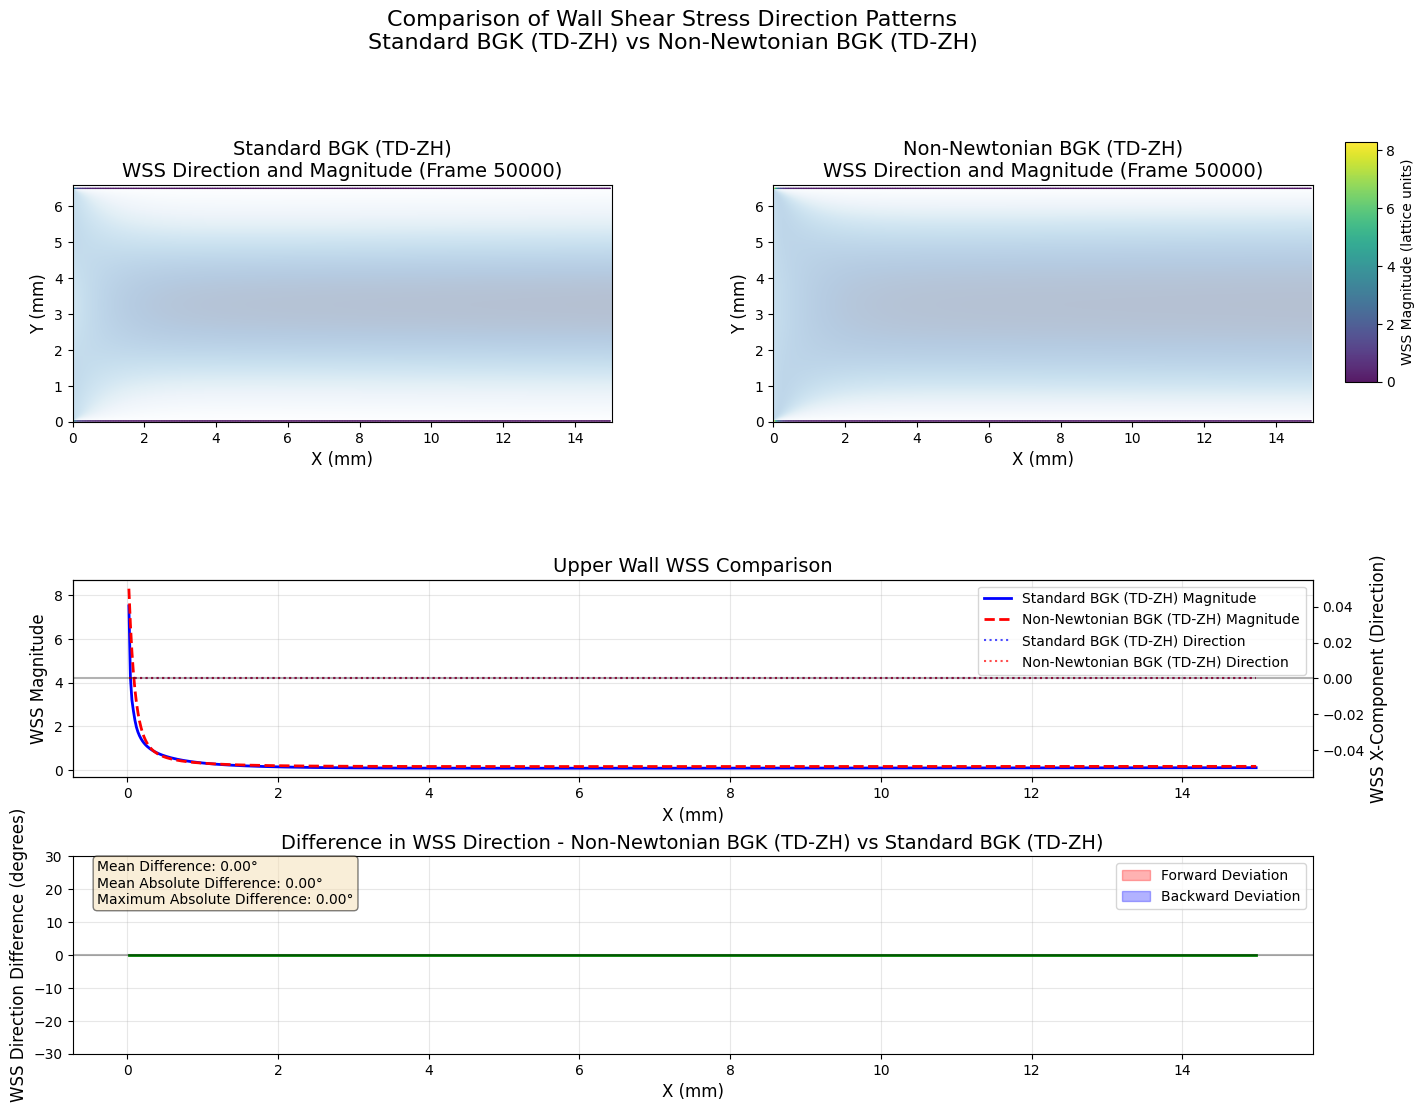

In [11]:
def compare_wss_directions(model1_velocity, model1_wss, model2_velocity, model2_wss, 
                         model1_name, model2_name, frame_idx=50, fig_size=(16, 12)):
    """Compare WSS direction patterns between two different models.
    
    Args:
        model1_velocity, model2_velocity (dict): Velocity data dictionaries for both models
        model1_wss, model2_wss (dict): WSS data dictionaries for both models
        model1_name, model2_name (str): Names of the models for display
        frame_idx (int): Frame index to compare
        fig_size (tuple): Figure size (width, height)
    """
    if any(data is None for data in [model1_velocity, model1_wss, model2_velocity, model2_wss]):
        print("Missing data for one or both models")
        return
    
    # Extract frame data for both models
    frame_numbers1 = model1_velocity.get('frame_numbers')
    frame_numbers2 = model2_velocity.get('frame_numbers')
    
    # Ensure the frame index is valid for both models
    if frame_idx >= min(len(frame_numbers1), len(frame_numbers2)):
        frame_idx = min(len(frame_numbers1), len(frame_numbers2)) // 2
        print(f"Frame index adjusted to {frame_idx}")
    
    # Get frame numbers for each model
    frame_num1 = frame_numbers1[frame_idx]
    frame_num2 = frame_numbers2[frame_idx]
    
    # Extract WSS components for the selected frame
    wss_mag1 = model1_wss.get('wss_magnitude')[frame_idx]
    wss_x1 = model1_wss.get('wss_x')[frame_idx]
    wss_y1 = model1_wss.get('wss_y')[frame_idx]
    
    wss_mag2 = model2_wss.get('wss_magnitude')[frame_idx]
    wss_x2 = model2_wss.get('wss_x')[frame_idx]
    wss_y2 = model2_wss.get('wss_y')[frame_idx]
    
    # Get velocity magnitude for background
    u_mag1 = model1_velocity.get('u_magnitude')[frame_idx]
    u_mag2 = model2_velocity.get('u_magnitude')[frame_idx]
    
    # Get dimensions and physical parameters
    ny, nx = u_mag1.shape
    dx = pipe_zh_bgk_key_params.get('dx', 2e-5)  # m/lu
    dt = pipe_zh_bgk_key_params.get('dt', 1e-5)  # s/ts
    
    # Get vessel parameters
    if pipe_zh_bgk_parameters is not None:
        vessel_centre_lu = pipe_zh_bgk_parameters['input_parameters'].get('vessel_centre_lu', ny // 2)
    else:
        vessel_centre_lu = ny // 2
    
    # Create wall masks for both models
    wall_mask1 = wss_mag1 > 0
    wall_mask2 = wss_mag2 > 0
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=fig_size)
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)
    
    # Create subplots for main visualizations
    ax1 = fig.add_subplot(gs[0, 0])  # Model 1 main plot
    ax2 = fig.add_subplot(gs[0, 1])  # Model 2 main plot
    
    # Plot for Model 1
    # -------------------------------------------------------------
    # Plot velocity magnitude as background
    im_vel1 = ax1.imshow(u_mag1, cmap='Blues', origin='lower',
                      extent=[0, nx*dx*1000, 0, ny*dx*1000], alpha=0.3)
    
    # Extract wall coordinates and WSS values
    y1_coords, x1_coords = np.where(wall_mask1)
    wss_vectors_x1 = wss_x1[wall_mask1]
    wss_vectors_y1 = wss_y1[wall_mask1]
    wss_magnitudes1 = wss_mag1[wall_mask1]
    
    # Convert to mm for display
    x1_mm = x1_coords * dx * 1000
    y1_mm = y1_coords * dx * 1000
    
    # Normalize vector lengths for better visualization
    # Use quiver to show direction with color representing magnitude
    vector_scale = 5.0
    # Set a maximum value for color normalization to ensure consistent colormaps between plots
    max_wss = max(np.max(wss_mag1), np.max(wss_mag2))
    norm = plt.Normalize(0, max_wss)
    
    q1 = ax1.quiver(x1_mm, y1_mm, wss_vectors_x1, wss_vectors_y1,
                  wss_magnitudes1, cmap='viridis', norm=norm,
                  scale=vector_scale, headwidth=3, headlength=4,
                  width=0.003, alpha=0.9)
    
    # Add title and labels
    ax1.set_title(f'{model1_name}\nWSS Direction and Magnitude (Frame {frame_num1})', fontsize=14)
    ax1.set_xlabel('X (mm)', fontsize=12)
    ax1.set_ylabel('Y (mm)', fontsize=12)
    
    # Plot for Model 2
    # -------------------------------------------------------------
    # Plot velocity magnitude as background
    im_vel2 = ax2.imshow(u_mag2, cmap='Blues', origin='lower',
                      extent=[0, nx*dx*1000, 0, ny*dx*1000], alpha=0.3)
    
    # Extract wall coordinates and WSS values
    y2_coords, x2_coords = np.where(wall_mask2)
    wss_vectors_x2 = wss_x2[wall_mask2]
    wss_vectors_y2 = wss_y2[wall_mask2]
    wss_magnitudes2 = wss_mag2[wall_mask2]
    
    # Convert to mm for display
    x2_mm = x2_coords * dx * 1000
    y2_mm = y2_coords * dx * 1000
    
    # Plot WSS vectors with the same scale as model 1
    q2 = ax2.quiver(x2_mm, y2_mm, wss_vectors_x2, wss_vectors_y2,
                  wss_magnitudes2, cmap='viridis', norm=norm,
                  scale=vector_scale, headwidth=3, headlength=4,
                  width=0.003, alpha=0.9)
    
    # Add title and labels
    ax2.set_title(f'{model2_name}\nWSS Direction and Magnitude (Frame {frame_num2})', fontsize=14)
    ax2.set_xlabel('X (mm)', fontsize=12)
    ax2.set_ylabel('Y (mm)', fontsize=12)
    
    # Add colorbar for WSS magnitude (shared between both plots)
    cbar_ax = fig.add_axes([0.92, 0.67, 0.02, 0.2])
    cbar = fig.colorbar(q2, cax=cbar_ax)
    cbar.set_label('WSS Magnitude (lattice units)')
    
    # Plot upper wall comparison
    # -------------------------------------------------------------
    ax3 = fig.add_subplot(gs[1, :])
    
    # Extract upper wall data for both models
    upper_wall_mask1 = y1_coords > vessel_centre_lu
    upper_wall_mask2 = y2_coords > vessel_centre_lu
    
    if np.any(upper_wall_mask1) and np.any(upper_wall_mask2):
        # Sort upper wall data by x-coordinate for both models
        x1_upper = x1_mm[upper_wall_mask1]
        wss_mag1_upper = wss_magnitudes1[upper_wall_mask1]
        wss_x1_upper = wss_vectors_x1[upper_wall_mask1]
        
        sort_idx1 = np.argsort(x1_upper)
        x1_upper = x1_upper[sort_idx1]
        wss_mag1_upper = wss_mag1_upper[sort_idx1]
        wss_x1_upper = wss_x1_upper[sort_idx1]
        
        x2_upper = x2_mm[upper_wall_mask2]
        wss_mag2_upper = wss_magnitudes2[upper_wall_mask2]
        wss_x2_upper = wss_vectors_x2[upper_wall_mask2]
        
        sort_idx2 = np.argsort(x2_upper)
        x2_upper = x2_upper[sort_idx2]
        wss_mag2_upper = wss_mag2_upper[sort_idx2]
        wss_x2_upper = wss_x2_upper[sort_idx2]
        
        # Plot WSS magnitude for both models
        ax3.plot(x1_upper, wss_mag1_upper, 'b-', linewidth=2, label=f'{model1_name} Magnitude')
        ax3.plot(x2_upper, wss_mag2_upper, 'r--', linewidth=2, label=f'{model2_name} Magnitude')
        
        # Create a secondary y-axis for directional components
        ax3_twin = ax3.twinx()
        
        # Plot WSS x-component (indicating flow direction) for both models
        ax3_twin.plot(x1_upper, wss_x1_upper, 'b:', linewidth=1.5, alpha=0.7, label=f'{model1_name} Direction')
        ax3_twin.plot(x2_upper, wss_x2_upper, 'r:', linewidth=1.5, alpha=0.7, label=f'{model2_name} Direction')
        ax3_twin.axhline(y=0, color='k', linestyle='-', alpha=0.3)  # Zero line
        
        # Add labels and titles
        ax3.set_xlabel('X (mm)', fontsize=12)
        ax3.set_ylabel('WSS Magnitude', fontsize=12)
        ax3_twin.set_ylabel('WSS X-Component (Direction)', fontsize=12)
        ax3.set_title('Upper Wall WSS Comparison', fontsize=14)
        
        # Add legends for both y-axes
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)
        
        # Add grid for readability
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No upper wall data available for comparison',
               horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    
    # Plot WSS direction deviation between models
    # -------------------------------------------------------------
    ax4 = fig.add_subplot(gs[2, :])
    
    # Create interpolation grid for calculating differences
    try:
        from scipy.interpolate import griddata
        
        # Create a common grid for both models
        x_common = np.linspace(0, nx*dx*1000, nx)
        y_common = np.linspace(0, ny*dx*1000, ny)
        X_common, Y_common = np.meshgrid(x_common, y_common)
        
        # Create masks for walls in both models
        y1_coords_upper = y1_coords[upper_wall_mask1]
        x1_coords_upper = x1_coords[upper_wall_mask1]
        wss_angle1 = np.arctan2(wss_vectors_y1[upper_wall_mask1], wss_vectors_x1[upper_wall_mask1]) * 180 / np.pi
        
        y2_coords_upper = y2_coords[upper_wall_mask2]
        x2_coords_upper = x2_coords[upper_wall_mask2]
        wss_angle2 = np.arctan2(wss_vectors_y2[upper_wall_mask2], wss_vectors_x2[upper_wall_mask2]) * 180 / np.pi
        
        # Convert to physical units (mm)
        x1_upper_mm = x1_coords_upper * dx * 1000
        x2_upper_mm = x2_coords_upper * dx * 1000
        
        # Sort by x position for plotting
        sort_idx1 = np.argsort(x1_upper_mm)
        x1_upper_mm = x1_upper_mm[sort_idx1]
        wss_angle1 = wss_angle1[sort_idx1]
        
        sort_idx2 = np.argsort(x2_upper_mm)
        x2_upper_mm = x2_upper_mm[sort_idx2]
        wss_angle2 = wss_angle2[sort_idx2]
        
        # Use interpolation to get values at common points for direct comparison
        # We need to ensure both datasets have enough points for interpolation
        if len(x1_upper_mm) > 5 and len(x2_upper_mm) > 5:
            # Find common x-range
            x_min = max(np.min(x1_upper_mm), np.min(x2_upper_mm))
            x_max = min(np.max(x1_upper_mm), np.max(x2_upper_mm))
            x_common = np.linspace(x_min, x_max, 100)
            
            # Interpolate angles for both models onto common x-grid
            from scipy.interpolate import interp1d
            
            # Handle potential angle wrapping/discontinuities by using complex numbers
            # Convert angles to complex numbers to handle wrapping
            complex1 = np.exp(1j * wss_angle1 * np.pi / 180)
            complex2 = np.exp(1j * wss_angle2 * np.pi / 180)
            
            # Interpolate real and imaginary parts separately
            real_interp1 = interp1d(x1_upper_mm, np.real(complex1), bounds_error=False, fill_value='extrapolate')
            imag_interp1 = interp1d(x1_upper_mm, np.imag(complex1), bounds_error=False, fill_value='extrapolate')
            
            real_interp2 = interp1d(x2_upper_mm, np.real(complex2), bounds_error=False, fill_value='extrapolate')
            imag_interp2 = interp1d(x2_upper_mm, np.imag(complex2), bounds_error=False, fill_value='extrapolate')
            
            # Compute interpolated values
            complex1_interp = real_interp1(x_common) + 1j * imag_interp1(x_common)
            complex2_interp = real_interp2(x_common) + 1j * imag_interp2(x_common)
            
            # Convert back to angles
            angle1_interp = np.angle(complex1_interp, deg=True)
            angle2_interp = np.angle(complex2_interp, deg=True)
            
            # Calculate angle difference (accounting for wraparound)
            angle_diff = (angle2_interp - angle1_interp + 180) % 360 - 180
            
            # Plot angle differences with colored bands
            ax4.plot(x_common, angle_diff, 'g-', linewidth=2)
            ax4.fill_between(x_common, 0, angle_diff, where=(angle_diff > 0), color='red', alpha=0.3, label='Forward Deviation')
            ax4.fill_between(x_common, 0, angle_diff, where=(angle_diff < 0), color='blue', alpha=0.3, label='Backward Deviation')
            
            # Add horizontal line at zero difference
            ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
            
            # Add labels and title
            ax4.set_xlabel('X (mm)', fontsize=12)
            ax4.set_ylabel('WSS Direction Difference (degrees)', fontsize=12)
            ax4.set_title(f'Difference in WSS Direction - {model2_name} vs {model1_name}', fontsize=14)
            
            # Set y-limits to focus on differences
            max_diff = max(abs(np.min(angle_diff)), abs(np.max(angle_diff)))
            y_limit = min(max(30, max_diff * 1.2), 180)  # Reasonable limits between 30° and 180°
            ax4.set_ylim(-y_limit, y_limit)
            
            # Add grid for readability
            ax4.grid(True, alpha=0.3)
            
            # Add legend
            ax4.legend(loc='upper right', fontsize=10)
            
            # Add statistics about direction differences
            mean_diff = np.mean(angle_diff)
            abs_mean_diff = np.mean(np.abs(angle_diff))
            max_abs_diff = np.max(np.abs(angle_diff))
            
            # Add text with statistics
            text_str = (f"Mean Difference: {mean_diff:.2f}°\n"
                       f"Mean Absolute Difference: {abs_mean_diff:.2f}°\n"
                       f"Maximum Absolute Difference: {max_abs_diff:.2f}°")
            
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax4.text(0.02, 0.98, text_str, transform=ax4.transAxes, fontsize=10,
                   verticalalignment='top', bbox=props)
            
        else:
            ax4.text(0.5, 0.5, 'Insufficient data points for direction comparison',
                   horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
    except ImportError:
        ax4.text(0.5, 0.5, 'scipy.interpolate is required for direction comparison',
               horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
    except Exception as e:
        ax4.text(0.5, 0.5, f'Error calculating direction differences: {str(e)}',
               horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
    
    # Add overall title
    plt.suptitle(f'Comparison of Wall Shear Stress Direction Patterns\n{model1_name} vs {model2_name}', fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

# Compare WSS direction patterns between standard BGK (TD-ZH) and non-Newtonian BGK (TD-ZH) models
try:
    # First, ensure TD-ZH BGK data is loaded if not already done
    if 'pipe_tdzh_bgk_velocity' not in globals() or pipe_tdzh_bgk_velocity is None:
        print("Loading TD-ZH BGK velocity data...")
        pipe_tdzh_bgk_velocity = load_velocity_data(pipe_tdzh_bgk_folder, "Pipe TD-ZH BGK")
    
    if 'pipe_tdzh_bgk_wss' not in globals() or pipe_tdzh_bgk_wss is None:
        print("Loading TD-ZH BGK WSS data...")
        pipe_tdzh_bgk_wss = load_wss_data(pipe_tdzh_bgk_folder, "Pipe TD-ZH BGK")
    
    # Use the middle frame for comparison
    middle_frame = min(len(pipe_tdzh_bgk_velocity['frame_numbers']), len(pipe_tdzh_nnbgk_velocity['frame_numbers'])) // 2
    print(f"\nComparing WSS direction patterns for frame {pipe_tdzh_bgk_velocity['frame_numbers'][middle_frame]}...")
    
    # Create the comparison visualization
    fig = compare_wss_directions(
        pipe_tdzh_bgk_velocity, pipe_tdzh_bgk_wss,
        pipe_tdzh_nnbgk_velocity, pipe_tdzh_nnbgk_wss,
        "Standard BGK (TD-ZH)", "Non-Newtonian BGK (TD-ZH)",
        frame_idx=middle_frame
    )
    plt.show()
    
except Exception as e:
    print(f"Error comparing WSS direction patterns: {e}")
    import traceback
    traceback.print_exc()